# the QT Easy Investment Research Platform
this is the development note and the first version of source codes of QT easy, the quants system -- quantatative investment system

along with the UML, these mark down texts are used to describe the basic functions of source codes, and plays as a suplement but important role a part from the comments in code lines


In [100]:
# -*- coding: utf-8 -*-  
import time
import pandas as pd
import tushare as ts
import numpy as np
from datetime import datetime
import datetime as dt
from abc import abstractmethod, abstractproperty, ABCMeta
import matplotlib.pyplot as plt
import itertools
from multiprocessing import Pool
import numba as nb
%matplotlib inline
try:
    from jupyterthemes import jtplot
    jtplot.style()
except:
    print ('jupyterthemes not loaded, themes can not be set!')
    print ('other functions can be used')
    print ('to use themes, install jupyterthemes first')
print ('pandas version:', pd.__version__)
print ('numpy version:', np.__version__)
print ('tushare version:', ts.__version__)

jupyterthemes not loaded, themes can not be set!
other functions can be used
to use themes, install jupyterthemes first
pandas version: 0.25.1
numpy version: 1.17.2
tushare version: 1.2.48


## QT easy base module
main interface to all sub modules

In [101]:
class Qteasy:
    '''QT Easy量化交易系统基础类.
    
    该类包含实盘交易模块、交易信号生成模块、以及参数库、宏观经济模块等四个模块
    '''
    def __init__(self, operator = None, history = None):
        self.__executor = Executor(self)
        self.__optimizer = Optimizer(self, operator = operator, history = history)
        self.__paramLib = ParamLib(self)
        self.__macro_economy = MacroEconomy(self)
    @property
    def optimizer(self):
        return self.__optimizer
    
class Context():
    '''QT Easy量化交易系统的上下文对象，保存所有相关环境变量及(伪)常量
    
    包含的常量：
        RUN_MODE_LIVE = 0
        RUN_MODE_BACKLOOP = 1
        RUN_MODE_OPTIMIZE = 2
        
    包含的变量包括：
        mode，运行模式
    '''
    def __init__(self):
        pass

### sub module Looper: 
Looper Module simulates trading transactions and provide historical trading simulation results with taking into consideration of trading rules, trading costs and time effects

The whole work is done in iterations. in order to speed up the iteration the dataframe is converted to an ndarray with using nditer as a fast iteration tool, further, the storage structure of the ndarray is properly set so that external loop can be used to loop over every row of the data frame instead of looping over each item in the matrix, thus the efficiency is high
##### step1: the operation list
the operation table listed all operations (buy-in or sell-out) in a time history list, the data is created in the Op module, as proposed operation signals. mind that the operation dates are sparse, that means we don't need to iterate over each open date during the whole history period

date | 000001 | 600848 | 600519 | 002442 
:-- | :--: | --:|:--: |:-- 
2019-01-01 | 0.2 | 0 | 0|0
2019-01-02 | 0 | 0.3 | 0 |0
2019-02-12 | 0 | -1 |0 |0
2019-02-13 | 0 |  0| 1 |0

##### Step2: the price matrix
the price history table contains historical price data of related investment products or shares:

we will have to extract partial of the data in a way that the dates of extracted records fit that of the operation list, in this way two lists are aligned and there is a row-to-row match of dates between two lists. therefore, when we iterate over two tables there's no need to worry about dates, and thus make it possible to use pure ndarrays with nditer

here's the original historical price list:

date | 000001 | 600848 | 600519 | 002442 
--| -- |--|--|--
2019-01-01 |1| 33.5 | 715.2 | 3.45
2019-01-02 |1| 34.5 | 720.3 | 3.57
2019-01-03 |1| 35.2 | 730.2 | 3.77
2019-01-04 |1| 35.7 | 720.3 | 3.79
... | ... | ... | ... | ...
2019-02-12 |1| 39.45 | 812.5 | 5.99
2019-02-13 |1| 40.15 | 828.1 | 6.24
2019-02-14 |1| 41.52 | 855.3 | 6.45

the extracted historical price data will have exactly the same set of date labels as the operation list: 

date | 000001 | 600848 | 600519 | 002442 
--| -- |--|--|--
2019-01-01 |1| 33.5 | 715.2 | 3.45
2019-01-02 |1| 34.5 | 720.3 | 3.57
2019-02-12 |1| 39.45 | 812.5 | 5.99
2019-02-13 |1| 40.15 | 828.1 | 6.24

##### Step3: iteration
before iteration above two tables are converted to ndarrays, and then use nditer plus external loop to enables us realize fast row-by-row iteration. in order to realize row-by-row or column-by-column iteration the ndarray should be stored in the memory differently as how external loop is set to carry out, meaning, if the ndarray is stored in memory in C-order then external loop should be carried out in Fortran-order and vise versa. therefore, we can not just conver the dataframe into ndarray by df.value, instead, we have to explicitly convert the DF into an array with np.array() with order = 'F' and loop with order = 'C', this will give us the desired result. if we would like to loop column-by-column then the array should be stored in C order and loop with 'F' order

with above setting, we will be able to carryout fast iteration with each row of the two dataframes being extracted at a time:

the share prices are extracted row by row, with prices of each share in the same day, forming a vector of float numbers, the price vector $ V_p$:

iteration steps | 000001 | 600848 | 600519 | 002442 
--| -- |--|--|--
step 1 -> |1| 33.5 | 715.2 | 3.45
step 2 -> |1| 34.5 | 720.3 | 3.57
step 3 -> |1| 39.45 | 812.5 | 5.99
step 4 -> |1| 40.15 | 828.1 | 6.24

thus in step 1: $$ V_p = [1, 33.5, 715.2, 3.45] $$

a second vector, the operations vector $V_o$, can also be extracted with the same manner from the operations matrix with all the operation signs of the same group of shares as in the price matrix:

iteration steps | 000001 | 600848 | 600519 | 002442 
:-- | :--: | --:|:--: |:--
step 1 -> | 0.2 | 0 | 0|0
step 2 -> | 0 | 0.3 | 0 |0
step 3 -> | 0 | -1 |0 |0
step 4 -> | 0 |  0| 1 |0

thus in step 1: $$V_o = [0.2, 0, 0, 0]$$

within each step of the iteration, above two vectors are extracted from each matrix to calculate all results.

##### Step 3.1 Iteration step:

In each iteration step, remaining cash, stock holdings and trading fee or trading costs are calculated according to previous step results. In order to initialize the calculation, an initial cash amount and stock holdings, a vector in the same dimension as the operation vector and price vector, are to be set. Then the results are calculated in following steps:

######  1, Calculate cash gained by selling out shares:

One gains cash by selling out shares in each step, and shares to be sold in the step are defined by the negtive values in the $V_o$, that represents the percentage of stock holdings to be turned into cash, thus the cash-gained $C_g$ and stock amount sold $AS$ can be calculated like this. in the fomular $AP_i$ is i-th element in previous stock holding amount Vector, $AS_i$ is the i-th element of Amount sold vector, $O_i$ is the i-th element in $V_o$, $P_i$ is the i-th element in $V_P$, and R_s is the trade cost rate of selling: 
$$AS_i = AP_i * O_i, where: O_i < 0 $$
$$C_g = \sum_{i=o}^{n}AS_i * P_i * (1 - R_s), where: O_i < 0 $$ 

###### 2, Calculate the cash spent and stock amount aqcuired:

After aqcuiring cash from stock amount sold, stock amount purchasing or aqcuiring and cash spent $C_s$ can be calculated as following: in the fomular V is the vector of Value of stock to be purchased, $PV$ is previous total value of investment, $O$ is the operation vector, $AG$ is amount purchased, $R_p$ is the purchase cost rate
$$V_i = PV * O_i, where: O_i > 0$$
$$AG_i = \frac{V_i}{P_i * (1 + R_p)}, where: O_i > 0$$
$$C_s = \sum_{i=0}^{n}AG_i * P_i * (1 + R_p), where: O_i > 0$$

In above fomulars, $ \sum V_i$ might not be the same as $ C_s $ because the actual purchased amount of stock might not be the same as that intended, due to the reason of purchasing quantity limitations, for example, given stock price 15 and intended purchasing value 10000, Amount gained $AG$ would be 10000 / 15 = 666.67 shares which, however, is not valid in current stock market, which allows the shares to be purchased in the multiple of 100, thus actually only 600 shares are purchased, thus $C_s = 600 * 15 = 9000$
###### 3, Calculate period end Stock amounts, cash, and trade cost

After calculationg of cash change and amounts change in above steps, period-end cash $C$ and amounts $A$ can be calculated:
$$C = C_p - C_s + C_g$$
$$A = AP + AG - AS$$
the trade cost is calculated by cumulating all the cost in each transaction of the same period:
$$fee = \sum_{i=0}^{n}Cs_i * R_p + \sum_{i=0}^{n}Cg_i * R_s$$

with above said, the looper takes total cash value, and stock holding amount from previous period as input, together with the operation codes and stock prices of current period, calculates what's after transactions: the cash and new amounts of stock holdings, which, in turn, will be used for next round of calculation. Thus a looper step function is compiled to complete all the work in one step, and numpy iterator np.nditer() is employeed to extract every row of data from the price and operation matrix, calculating transaction results. 

###### 4, Cash investment plan (FUNCTION TO BE COMPLETED!!)

In the simplest case, cash investment can be viewed as one time investment at the beginning of whole investment period. In this looping model, a simple initial cash value is asigned to the looper iteration. however, a more sufisticated solution of simulating cash investment is a cash plan table, that contains the amount of cash investment or extraction on different dates. 

date | cash 
:-- | :--: 
2019-01-01 | 20000
2019-02-12 | 10000 

before looping iteration the cash investment table is also converted into numpy ndarray that has the same number of rows of data as the operation / price matrix, further, the dates of each row are also aligned with that of the other two matrices, so that the correct value of cash can be extracted while date comparison is not needed:

date | cash 
:-- | :--: 
2019-01-01 | 20000
2019-01-02 |0
2019-02-12 | 10000 
2019-02-13 |0

date | cash 
:-- | :--: 
Step 1 -> | 20000
Step 2 -> |0
Step 3 -> | 10000 
Step 4 -> |0

then during the iteration, the value of cash extracted from the ndarray can be simply added to the total cash in each period $C_{Inv}$ is the value of invested cash in the period:
$$C = C_p =C_s + C_g + C_{Inv}$$

##### Step 4, output of results
with iterations of looping over historical/operational data the result matrix can be created also as an ndarray of stock holding amounts and list of cash, total investment values in each period. these matrices contains adequate infomration for most types of performance analysis and assessments, however, sometimes it is required fo display or visualize the complete historical list or convert current data in a different historical frequency.

Thus a special function is created to complete all the data that has been removed because their operation codes are empty. This task is fairly easy because since there are no operation codes during these days the stock holding amount and cash will remail the same, thus value can be easily calculated.

In [102]:
class Looper:
    '''回测器类，获取历史数据以及历史交易信号数据，根据交易信号进行模拟交易并计算模拟交易历史记录，
    
    包括每次交易前后的现金持有额、投资产品持有额、交易费用及交易成本额等
    交易信号清单和资产价格清单是Looper类主要函数apply_loop()的主要输入参数，根据这两个输入参数
    apply_loop()函数返回模拟交易记录
    '''
    def __init__(self, superior, rate_fee = 0.003, rate_slipery = 0, rate_impact = 0, MOQ = 100):
        '''初始化回测器类,初始化回测器对象相关变量，主要包括计算交易费用的变量
        
        输入
            参数superior, object:上级模块，本模块在创建时必须作为上级模块的子模块创建，通过该参数可以访问上级模块
            参数rate_fee, float：交易费率，用于计算交易费用
            参数rate_slipery, float：滑点影响率，用于计算交易滑点成本
            参数rate_impact, float：冲击成本率，用于计算冲击成本
            参数MOQ, float：最小购买单位，表示购入金融产品时最低可购买的份额数量，
        输出：
            无
        '''
        self.__superior = superior #上层对象
        self.rate_fee = rate_fee #交易费用成本计算参数，固定交易费率
        self.rate_slipery = rate_slipery #交易滑点成本估算参数，对交易命令发出到实际交易完成之间价格变化导致的成本进行估算
        self.rate_impact = rate_impact # 交易冲击成本估算参数，对交易本身对价格造成的影响带来的成本进行估算
        self.MOQ = MOQ # 交易最小批量，设置为0表示可以买卖分数股
    @property
    def superior(self): 
        '''返回Looper类的上层对象'''
        return self.__superior
    def info(self):
        '''打印Looper类的基本参数信息'''
        print (self.rate_fee)
        print (self.rate_slipery)
        print (self.rate_impact)
        print (self.MOQ)
        
    def __loop_step(self, pre_cash, pre_amounts, op, prices, rate_in = 0.0015, rate_out = 0.0015):
        ''' 对单次交易进行处理，采用向量化计算以提升效率
        
        输入：
            参数 pre_cash, ndarray：本次交易开始前账户现金余额
            参数 pre_amounts, ndarray：list，交易开始前各个股票账户中的股份余额
            参数 op, ndarray：本次交易的个股交易清单
            参数 prices：List，本次交易发生时各个股票的价格
            参数 rate_in：买入成本——待改进，应根据三个成本费率动态估算
            参数 rate_out：卖出成本——待改进，应根据三个成本费率动态估算
        
        输出：元组，包含四个元素
            cash：交易后账户现金余额
            amounts：交易后每个个股账户中的股份余额
            fee：本次交易总费用
            value：本次交易后资产总额（按照交易后现金及股份余额以及交易时的价格计算）
        '''
        MOQ = self.MOQ
        # 计算交易前现金及股票余额在当前价格下的资产总额
        pre_value = pre_cash + (pre_amounts * prices).sum() 
        # 计算按照交易清单出售资产后的资产余额以及获得的现金
        '''在这里出售的amount被使用np.rint()函数转化为int型，这里应该增加判断，如果MOQ不要求出售
        的投资产品份额为整数，可以省去rint处理'''
        if MOQ == 0:
            a_sold = np.where(prices != 0, 
                              np.where(op < 0, pre_amounts * op, 0),
                              0)
        else:
            a_sold = np.where(prices != 0, 
                              np.where(op < 0, np.rint(pre_amounts * op), 0),
                              0)
        cash_gained = np.where(a_sold < 0, -1 * a_sold * prices * (1 - rate_out), 0)
        # 本期出售资产后现金余额 = 期初现金余额 + 出售资产获得现金总额
        cash = pre_cash + cash_gained.sum()
        # 初步估算按照交易清单买入资产所需要的现金，如果超过持有现金，则按比例降低买入金额
        pur_values = pre_value * op.clip(0) # 使用clip来代替np.where，速度更快,且op.clip(1)比np.clip(op, 0, 1)快很多
        if pur_values.sum() > cash:
            # 估算买入资产所需现金超过持有现金
            pur_values = pur_values / pre_value * cash
            # 按比例降低分配给每个拟买入资产的现金额度
        # 计算购入每项资产实际花费的现金以及实际买入资产数量，如果MOQ不为0，则需要取整并修改实际花费现金额
        if MOQ == 0: # MOQ为零时，可以购入的资产数量允许为小数
            a_purchased = np.where(prices != 0,
                               np.where(op > 0,
                                        pur_values / (prices * (1 + rate_in)), 0), 0)
        else: # 否则，使用整除方式确保购入的资产数量为MOQ的整数倍，MOQ非整数时仍然成立
            a_purchased = np.where(prices != 0,
                               np.where(op > 0,
                                        pur_values // (prices * MOQ * (1 + rate_in)) * MOQ,
                                        0), 0)
        # 由于MOQ的存在，需要根据实际购入的资产数量确定花费的现金资产
        # 仅当a_purchased大于零时计算花费的现金额
        cash_spent = np.where(a_purchased > 0,
                              -1 * a_purchased * prices * (1 + rate_in), 0)
        
        # 计算购入资产产生的交易成本，买入资产和卖出资产的交易成本率可以不同，且每次交易动态计算
        fee = np.where(op == 0, 0,
                       np.where(op > 0, -1 * cash_spent * rate_in,
                                cash_gained * rate_out)).sum()
        # 持有资产总额 = 期初资产余额 + 本期买入资产总额 + 本期卖出资产总额（负值）
        amounts = pre_amounts + a_purchased + a_sold
        # 期末现金余额 = 本期出售资产后余额 + 本期购入资产花费现金总额（负值）
        cash += cash_spent.sum() 
        # 期末资产总价值 = 期末资产总额 * 本期资产单价 + 期末现金余额
        value = (amounts * prices).sum() + cash
        return cash, amounts, fee, value
    def _get_complete_hist(self, values, history_list, with_price = False):
        '''完成历史交易回测后，填充完整的历史资产总价值清单
        
        输入：
            参数 values：完成历史交易回测后生成的历史资产总价值清单，只有在操作日才有记录，非操作日没有记录
            参数 history_list：完整的投资产品价格清单，包含所有投资产品在回测区间内每个交易日的价格
            参数 with_price：Bool，True时在返回的清单中包含历史价格，否则仅返回资产总价值
        输出：
            values，pandas.Series 或 pandas.DataFrame：重新填充的完整历史交易日资产总价值清单
        '''
        # 获取价格清单中的投资产品列表
        shares = history_list.columns
        # 使用价格清单的索引值对资产总价值清单进行重新索引，重新索引时向前填充每日持仓额、现金额，使得新的
        # 价值清单中新增的记录中的持仓额和现金额与最近的一个操作日保持一致，并消除nan值
        values = values.reindex(history_list.index, method = 'ffill').fillna(0)
        # 重新计算整个清单中的资产总价值，生成pandas.Series对象
        values = (history_list * values[shares]).sum(axis = 1) + values['cash']
        if with_price: # 如果需要同时返回价格，则生成pandas.DataFrame对象，包含所有历史价格
            values = pd.DataFrame(values.values, index = history_list.index, columns = ['values'])
            values[shares] = history_list[shares]
        return values
    def apply_loop(self, op_list, history_list, visual = False, price_visual = False,
                   init_cash = 100000, rate_fee = 0.003, rate_slipery = 0, rate_impact = 0, MOQ = 100):
        '''使用Numpy快速迭代器完成整个交易清单在历史数据表上的模拟交易，并输出每次交易后持仓、
            现金额及费用，输出的结果可选
        
        输入：
            参数 op_list：标准格式交易清单，描述一段时间内的交易详情，每次交易一行数据
            参数 history_list：完整历史价格清单，数据的频率由freq参数决定
            参数 visual：可选参数，默认False，仅在有交易行为的时间点上计算持仓、现金及费用， 
                            # 为True时将数据填充到整个历史区间，并用图表输出
            参数 price_visual：选择是否在图表输出时同时输出相关资产价格变化，visual为False时无效
            参数 init_cash：初始资金额
        
        输出：
            Value_history：包含交易结果及资产总额的历史清单
        '''
        self.rate_fee = rate_fee
        self.rate_slipery = rate_slipery
        self.rate_impact = rate_impact
        self.MOQ = MOQ
        if op_list.empty: return op_list
        # 将交易清单和与之对应的价格清单转化为ndarray，确保内存存储方式为Fortune，
        # 以实现高速逐行循环批量操作
        op = np.array(op_list.values, order = 'F')
        price = np.array(history_list.fillna(0).loc[op_list.index].values, order = 'F')
        # 初始化计算结果列表
        cash = init_cash # 持有现金总额，初始化为初始现金总额
        amounts = [0] * len(history_list.columns) # 投资组合中各个资产的持有数量，初始值为全0向量
        cashes = [] # 中间变量用于记录各个资产买入卖出时消耗或获得的现金
        fees = [] # 交易费用，记录每个操作时点产生的交易费用
        values = [] # 资产总价值，记录每个操作时点的资产和现金价值总和
        amounts_matrix = []
        # 只有当交易的资产数量大于1时，才需要向量化逐行循环，否则使用默认的ndarray循环
        if len(history_list.columns) > 1:
            # ndarray的内存存储方式和external loop的循环顺序不一致时，会产生逐行循环的效果，实现向量化计算
            it = np.nditer([op, price], flags = ['external_loop'], order = 'C')
        else:
            it = np.nditer([op, price])
        # 将每一行交易信号代码和每一行价格使用迭代器送入_loop_step()函数计算结果
        for o, p in it:
            # 使用单次交易计算函数计算本期交易后的现金、资产持有余额，以及交易费用和总价值
            cash, amounts, fee, value = self.__loop_step(pre_cash = cash,
                                                        pre_amounts = amounts,
                                                        op = o, prices = p, 
                                                        rate_in = 0.0015, rate_out = 0.0015)
            # 保存计算结果
            cashes.append(cash)
            fees.append(fee)
            values.append(value)
            amounts_matrix.append(amounts)
        # 将向量化计算结果转化回DataFrame格式
        value_history = pd.DataFrame(amounts_matrix, index = op_list.index,
                                     columns = op_list.columns)
        # 填充标量计算结果
        value_history['cash'] = cashes
        value_history['fee'] = fees
        value_history['value'] = values
        if visual: # Visual参数为True时填充完整历史记录并
            complete_value = self._get_complete_hist(values = value_history,
                                                     history_list = history_list,
                                                     with_price = price_visual)
            # 输出相关资产价格
            if price_visual: # 当Price_Visual参数为True时同时显示所有的成分股票的历史价格
                shares = history_list.columns
                share_prices = []
                complete_value.plot(grid=True, figsize=(15,7), legend=True,
                                    secondary_y = shares)
            else: # 否则，仅显示总资产的历史变化情况
                complete_value.plot(grid=True, figsize=(15,7), legend=True)
        return value_history

In [103]:
class MacroEconomy:
    '宏观经济类'
    def __init__(self, superior):
        self._superior = superior

### Sub Module Optimizer:
given a portfolio and historical data, find out optimal set of strategy parameters in a way that generates best result given by one of the evaluation functions. This module automatically detects all the parameters that need to be optimized for the strategy, or take as input part of the parameters to optimize, adjust the paramters systematically and repetitively feed the paramters into the strategy signal generator and calculates Looping results on given historical data sets. by comparing looping evaluation results from each and every epoch of tests, the Optimizer module finally decides and output the parameters that generates the best looping results.

This module contains multiple sub-modules and components:

* **Space Class**: that defines the parameter vector space in which optimizer searchs for optimal points, the space can be discret or continuous, or even enumerates of objects, Space class defines the space and create list of extracted points for optimization
* **Evaluation module**: it evaluates the results provided by Op and Loop module, by providing result of KPI
* **Optimization module**: depending on which optimizing algorithm is chosen, extracts points from the searching space and calculates their performances by applying Op, Looper and Evaluator, and finds out the global optimal, local optimal or near optimal points.

#### Space Class
Space Class generates and operates on parameter spaces that contain all possible combinations of parameter elements. For example, the typical DMA timing strategy is defined by three different parameters: (sma, lma, m): 
1. **sma**: the short moving average window
1. **lma**: the long moving average window
1. **m**: the difference average window

All of the three parameters are integers that ranging typically from 1 to 300, then complete set of MACD parameter is a tuple of three integers and can be seen as a point in a typical three dimensinal space so called the **Parameter Space**, and the parameter space of MACD strategy is defined, according to the character of MACD strategy, as that formed by all the integer points in 3-D space whose coordinates ranges between 1 to 300, and each dimension of the space, representing one element of parameters, is defined as an **Axis Object**, in which the range of possible values are defined.

In the MACD space, the points in the space are discrete and the space is a so-called **Discrete space**. if any of the parameters is a real number, for example, the strategy "N day percent drop", the percentage of N-day drop can be any real number, the space thus contains a **Continuous Axis**, which means coordination of points in the space can be any number.

Apart from pure number axis, the Space class also supports an enumerate type of axis, that contains a variaty of different type of data, and can be used flexibly. For example, the cross line strategy has a txt type of parameter ('buy' or 'sell'), which can be described as an enumerate axis, representing two possible values of this parameter. 

The dimension of the parameter space depends on strategy. A space object contains multiple Axis objects, representing one dimension or one element in the parameter group, each containing either upper and lower boundary of possible value of the parameter element, or an enumeration of all possible values. 

#### Iteration over space

##### Uniformal Iteration
The major output of a space object is an iterator on all or a sub set of its elements, determined by a key extraction factor that is called step size, meaning the distance between two neibouring extracted parameter data points. For example, a simple 2-dimensional space may contain all possible interger pairs from (0, 0) to (100, 100), and can be written down as a matrix like this: 

\begin{array}{ccc}
(0,0)&(0,1)&(0,2)&\dots&(0,100)\\
(1,0)&(1,1)&(1,2)&\dots&(1,100)\\
(2,0)&(2,1)&(2,2)&\dots&(2,100)\\
\vdots&\vdots&\vdots&\ddots&\vdots\\
(100,0)&(100,1)&(100,2)&\dots&(100,100)\\
\end{array}

Extracting data from above parameter space with a step factor of 5 means to generate a sub set of parameter pairs along every axis by selecting the items with an incremenets of 5, e.g, following points are selected: 

\begin{array}{ccc}
(0,0)&(0,5)&(0,10)&\dots&(0,100)\\
(5,0)&(5,5)&(5,10)&\dots&(5,100)\\
(10,0)&(10,5)&(10,10)&\dots&(10,100)\\
\vdots&\vdots&\vdots&\ddots&\vdots\\
(100,0)&(100,5)&(100,10)&\dots&(100,100)\\
\end{array}

which resulting in a much smaller set of data that are uniformly distributed over the whole parameter space. of cause, the step factor can be set to 1 to create a sub-set of parameters which are exactly the same as the whole space. in case of continuous parameter space, such as the space containing all real number pairs between (0, 100), there are indefinete number of points in the space, and the step factor can be set to between 0 and 1 to provide a fairly large subset of space, for example, extracted subset from above mensioned space with step factor of 0.2 will end up with a sub set of parameters as following:

\begin{array}{ccc}
(0.0,0.2)&(0.0,0.4)&(0.0,0.6)&\dots&(0.0,100.0)\\
(0.2,0.2)&(0.2,0.4)&(0.2,0.6)&\dots&(0.2,100.0)\\
(0.4,0.2)&(0.4,0.4)&(0.4,0.6)&\dots&(0.4,100.0)\\
\vdots&\vdots&\vdots&\ddots&\vdots\\
(100.0,0.2)&(100.0,0.4)&(100.0,0.6)&\dots&(100.0,100.0)\\
\end{array}

In case of an enumeration type of Axis, the step factor works as well (the second parameter is an enumerate Axis containing letters 'A', 'B', 'C', ... 'Z'):

\begin{array}{ccc}
(0,A)&(0,F)&(0,K)&\dots&(0,U)\\
(5,A)&(5,F)&(5,K)&\dots&(5,U)\\
(10,A)&(10,F)&(10,K)&\dots&(10,U)\\
\vdots&\vdots&\vdots&\ddots&\vdots\\
(100,A)&(100,F)&(100,K)&\dots&(100,U)\\
\end{array}

##### Random Iteraiton (Montecarlo)

For any type of space, random extraction or iteration over its elements is available as well. Instead of step size in the uniform iteration, the total number of points to be extracted is provided as key parameter of extraction. For example, one can extract 16 points randomly from a 2D space [(0, 1), (0, 1)]:

\begin{array}{ccc}
(0.05 , 0.955)&(0.726, 0.381)&(0.069, 0.89 )&(0.848, 0.782)\\
(0.122, 0.233)&(0.255, 0.371)&(0.26 , 0.496)&(0.033, 0.576)\\
(0.764, 0.068)&(0.728, 0.236)&(0.221, 0.949)&(0.063, 0.641)\\
(0.635, 0.706)&(0.499, 0.236)&(0.984, 0.336)&(0.171, 0.896)\\
\end{array}

Random or Montecarlo extraction works as well for Spaces containing descrete and enumerate types of Axis

##### Conversion to Iterators

The points extracted from Spaces are packed into an iterator object, so that all of the points in the itertor will be sent to Operation and Looper module for investment operation creation and result simulations. the module itertools is imported to do so. 

#### Evaluation Module

To find out the optimal strategy parameters, the output of investment simulation should be evaluated in a certain way. There are multiple different types of evaluation methods can be adopted, each with its own advantages and disacvantages. choose carefully between those evaluation methhods might help identify the best strategy. 

All the evaluation methods are defined in the evaluation module as functions that take as input the complete historical investment operation record, and output a float number, the so called performance indicator, that represents the performance of the parameters.

##### Final Value (FV)

Final value is the most natural and strait forward indicator of the performance of strategy. just by simply taking the total value of all investment products and cash as the value of evaluation function output, we can conclude that the strategy is performing better if the FV is higher, of cause the investment period and initial investment should be exactly the same to make sure and apple-to-apple comparison.

#### Optimization Module

Optimization is the process of searching for the best performing parameter of a given strategy in the parameter space, normally, consisting millions or billions of legal combimations of parameters. The target, defined as the one or more set of parameters that generates the best performance on a given investment period with given investment initial plan over the whole space, is called the **Global Optimal** parameter, and is the ultimate goal of the process; however, due to the enormity of space and the size of parameter combinations to be checked and tested, normally we are also satisfied with a "good enough" set of parameters that performes better than enough number of its nabours, which is refered to as the **Local Optimal** parameter.

depending on the size, type and character of parameter spaces, there are multiple ways of searching for global or local optimal parameters. The Optimization Module consists of multiple optimization algorithms which, although varies a lot in many ways, employes the Space object to extract multiple parameters from the parameter space, sends parameters to evaluation module for performance evaluation by creating simulated investment result on pre-given historical period and investment plan, and somehow "washes away" sub-optimal parameters or climbs to the optimal results.

##### Exauhstive Searching

The Exauhstive searching algorithm is the simplest algorithm of all, that one just checks every and all possible parameter combinations in the parameter space, and compare their performances with each other one at a time. a performance pool, containing pre-given numbers of parameter sets, is created at the begining of the algorithm. Each and every parameter in the space is extracted and compared with all the parameters in the pool and put into the pool to replace the least performing parameter in the pool only if it out-performs it. After iteratively checking all the parameters in the space, the **GLABAL OPTIMAL** parameters are then found and stored in the pool.

The nature of exauhstive searching is global and slow, thus it makes this algorithm not suitable for very large parameter spaces, which may contain billions of parameters. if it takes 1 millisecond to check one set of parameter, checking all 1 billion sets of parameters will cost one million seconds, which is 11.6 days. In such sircumstances, a sub-exauhstive searching algorithm should be employed to achieve balancing between performance and time. But in this case, Glocal optimal solution may not be garanteed, what we achieve finally will probably be only a local optimal.

There is a parameter of *step size* for the algorithm, which is 1 for default, controls the step size by which the algorithm extracts the neibouring points. setting this parameter to be more than 1, for instance, 2, will reduce the total number of parameters to be checked to $2^n$ -th of how much it would have been if the step size were 1, but of cause that means the Global optimal parameter may simply be omitted during iteration. Nevertheless, even in the worst case the global optimal parameter will only be 1 step away from one of the checked value, which will very likely to be one of the local optimal unless the function of the performance on the parameter space is purely random and are irelevant to each other.

Another drawback of the exaustive searching algorithm is that it does not work for continuous Axis, simply because it is impossible to exauhst all the real numbers on the number axis. no matter how small or how short the distance between lower and upper boundary is. Applying exaustive searching algorithm on a space containing continuous axis  means taking numbers along the continuous axis at a step of 1, such as: 

$$1.5, 2.5, 3.5, 4.5, 5.5, \dots, 100.5$$

The parameter of *stepsize* can be either a number, in such case the algorith automatically applys the same step size along all the axis of the space, or a list containing multiple numbers, in which case different step sizes are applied on the axes. The length of the list of numbers does not have to be the same as the dimension of the space, the module pads missing numbers with 1 or omitts the eccessive numbers given in the list. For example, if a *stepsize = [2, 2]* is given for a 4-dimensional space, the step sizes are automatically padded to [2, 2, 1, 1] and then applied to four dimensions of the space respectively

##### MonteCarlo Searching

MonteCarlo Searching algorithm is one that searches only part of the parameter space, by uniformally or randomly picking up points from the parameter spaces, a fairly good coverage of points in the space is guarenteed and thus allow us a very good chance of achieving a value very close to the global optimal or next to the global optimal value while in the same time drastically reducing the number of parameter sets need to be checked. 

Two major forms of MonteCarlo searching can be performed according to how the parameter points are taken out from the space, a uniform one and random one. In former form a step size is given as the key parameter of the algorithm and point count for the latter. Now the uniformal way of extraction is integrated with the exauhstive searching, and the MonteCarlo searching here provides only random selection of points out of the space.

This Algorithm does not work directly by letting you to specify the total number of points to take from the space, instead, it requires the user to specify a list of numbers , each representing the number of coordinates to be taken randomly from each of the axis of the space, and combine all these coordinates into parameter sets. However, the algorithm automatically pads single number into complete list of numbers by duplicate the same number on each dimension. For example, `point_count = 100` for a 3-D space equals to `point_count = [100, 100, 100]`, and 100 number of random points will be taken out on each axis.

Therefore, if `point_count = [100, 100, 100]` is given for a 3-D space then one million ($100*100*100=1,000,000$) total points will be extracted from the space. By allowing and requesting users to specify for each axis the number of coordinates to be extracted provides more manipulation and flexibility to the users.

It can be assumed that, due to its randomality nature, the number of points taken out from each axis is not limited to the total count of points in the axis. That means if one of the axis has only 100 points, one can still specify 200 as the point count of this parameter, it means that a number will be randomly picked out of the 100 numbers for 200 times, and then coordicate with other numbers or points picked from other axis, forming sets of parameters.

Apart from how the parameters are taken and generated from the space, the following steps of optimization are exactly the same as those of exauhstive searching: A pool object is designated to store all the result generated, compared and out-performed existing parameters, and finally, by washing our all sub-performing parameters, identify all the best parameters extracted from the space.

Further, since the points are taken randomly from the space, the MonteCarlo searching is suitable for all types of axes.

##### Incremental Steped Searching (ISS)

The ISS algorithm is designed to seek a better balance between closeness to the **Global Optimal** and total number of parameters to be checked, which is, to some extent, already attended to in the step-sized exauhstive searching and MonteCarlo searching. The ISS algorithm takes one big step forward if the space meets a certain criteria and achieves much faster execution speed and a very good chance to achieve the **GLOBAL OPTIMAL**

The assumption for the algorithm works is that the extent of continuity of performances of parameters in the space. Here continuity is defined as one of the key features of the performances of the points taken from the space: if the performance value of a point from the space is relatively close to those of its neibours, and the distance between them tends to increase as compare to further neibours, then we can say that the performance of parameters are largely continuous. In other words, the continuity reveals the fact that high performers are somewhat close to each other, and low-performers likewise.

Imagine a map with altitude of terrain marked on it, the altitude of any point on the coordination of the map represents the performance of the parameter consisted with the two numbers longtitude and latitude. In most of the maps the terrains are continuous in a way that very sharp cliffs are very rare, thus the altitude of any two points very closed to each other are also close to each other. And in a large birds view we can see mountains and valleys over the terrain, the work of looking for the global optimal point is equal to finding the ultimate point of mountain in the area.

Looking for the ultimate point in the area using exauhstive searching algorithm means check the altitude of all points on the intersections of a mesh of 1 meter grid over the area, which obviously, is a tiresome job, because there might be billions of points to check. 

However, the facts that the terrains are continuous allows us to adopt a much faster way of pin pointing the exact location of the ultimate peak. intuitively, we can start with a very rough searching over the area by searching the intersections of a mesh of grids with much larger distance, for example, of 1000 meters. It will be very unlikely that one of the points is the exact ultimate, but because of the continuity character of the terrain, the higher points that we found might well be more likely to be closer to the ultimate peak, and the beauty of searching at such large step size is that the number of searching points are very little, and we can very quickly find multiple points that are higher than other points.

Next, we will re-start the searching at a smaller step size, let's say, of 200 meters, but only "around" those points whose altitudes are higher than the others. The reason why we don't search only the perenfersis of **the current highest point** is that the current highest may only close to a local peak instead of a global peak. thus we will search all the neibouring area of multiple high points. Because we have already start from a few higher points, we may say we start from either half way up the mountains or already on the mountains. we may safely conclude that if we search only around those points it is more likely for us to be closer to the ultimate points, which we will because in the second round of searching we simply remove those points that are lower, in which case means we are farther away from the peak, and keep those points that are higher, probably higher than current ones.

The searching like this will go in rounds, with each round reduced size of searching step, and only on the higher points found in previous round. In such iterations we finally converge to the single point or multiple points of highest peak when the searching step reduces to 1 meter and searching area to 1.

In order to ensure a proper coverage of searching area a practical strategy is to start searching with step size of $2^n$, and keep 50 highest points, and in next rounds of searching reduce the step size by half and search the area around each highest points from previous round across the distance of $2^n$ over every axis, until step size is 1. In this way we can guarrantee complete coverage of searching area.

The practical algorithm has following four parameters:

- **output_count** the number of points around which the neibours are searched in the next round
- **init_step** the searching step size in the first round of searching
- **inc_step** incremental step, the multiply factor with which step size divides after each round
- **min_step** minimum step size, stop the cycle while current step size is smaller than minimum size

Once initial step size is decided, the algorithm performes the first round of searching just like exauhstive searching with step size equal to initial step size, and store the same number of results in the pool as output_count. For each of the results in pool, a sub space is created that covers just its neibouring area. After one round of searching, all of the sub spaces are searched with smaller step size, and the best results of all sub spaces are stored in the pool, again. Above process is repeated until the step size is too small.

The performance of ISS can be very high -- if parameters properly chosen, ISS can be thousands of times faster than exauhstive searching, while still keep reasonably good hit rate on global optimal. The largest concern of using ISS is that the performance function being not continuous. Further, the selection of initial step size is also critical, the more continuous the performance function is, the larger the initial step size may be. While larger initial step size helps a lot in reducing total calculating time, it increases the chance for missing the global optimal point. However, increasing output_count might mitigate that effect.

Finally, although the ISS algorithm does imporve a lot the performance of exauhstive searching algorithms, it does not change foundamentally its exauhstive searching nature, and does not exceed its limitation: that these algorithms are not suitable for ultra-dimensional parameter spaces. For normal and traditional investment strategies the parameter dimensions are normally small, traditionally people can not process parameter which is more than 10-dimensional. 

However, new methods and algorithms related to machine learning and big data started to utilize ultra-large parameter spaces. Imagine that we would like to find out the optimal operation in past 2000 trade days directly from all possible legal operations. Consider the simplest situation in which we can choose to buy, sell, or hold the investment product in each trade day, thus the parameter space is a 2000-D space with each dimension have 3 possible values: buy, sell, hold. Such ultra-huge space has $3^{2000}$ possible combinations and NONE of above algorithms is capable of solving the problem in a reasonable period of time. For such problems, new concepts has to be adopted, there are multiple machine learning algorithms are potentially possible 

##### Genetic Algorithm Searching (GA)

Genetic Algorithm is one of the algorithms that are capable of searching for global / local optimal in ultra-large spaces.

Genetic algorithm simulates the process of biological genetic hybriding and mutation that improves adaptivity of biological populations during the evolvement in given environment. The algorith takes place in multiple, in most cases thousands or even millions of, iterations, in which a "population" of parameters live or die, and reproduce at a certain percentage that is related to the adaptivity of each individule in the population, the higher one parameter performs, the higher the chance for it to give off sprint and survive, or vise versa. In other words, in each iteration, the high-performers are more likely to survive, and repreduce -- passing its own gene to the next generation -- and then given enough time of regeneration, the good genes -- the part of the parameter that tends to generate higher result -- will cumulate to an extent that formulate the global optimal solution in the space.

The algorithm starts with a fixed population randomly selected from the space, for example 1000 individule parameters. Each individule is evalated and its adaptivity is calculated according to its performance, based on which its surviving rate and repreducing rate being calculated. Then, following actions take place on each individule: 

- **SURVIVE**: that the individule will survive to the next generation
- **DIE**: that the individule will NOT survive to the next generation
- **REPREDUCE** that the individule will repreduce an offsprint, there are basically two different ways of reproducing:
   - **SWAPPING**: that the offspring is generated by combining part from individule A and the other part from individule B
   - **REPLACING**: that the offspring is generated by replacing a small part of the parent individule with a new random section
- **MUTATION**: that a small change is applied randomly on a single gene of the individule

##### Artificial Neural Networks (ANN)

In [104]:
class Optimizer():
    '参数优化器类，在指定的历史区间上使用多种算法，在指定的参数空间中搜索最佳参数组合，使得特定的评价函数值'
    '最大化，并对搜索到的最佳参数进行管理， Looper对象用于根据操作清单模拟交易并输出交易结果'
    # 类属性：
    # optization period 优化区间：指优化器尝试进行参数优化基于的历史区间，优化器可以利用优化区间内的历史数据
    # 优化参数，同时在测试区间对参数进行评价，以便对搜索到的参数进行独立验证
    # 优化区间类型：1: 参数优化区间与测试区间相同；2:优化区间与测试区间不同；3:重叠设置一系列优化区间与测试区间
    opt_period_type_dict = {1: 'simple', 2: 'standard', 3: 'convolutional'} 
    # 目标函数：评价一组参数的效用的函数，定义使得该函数值最大化的一组参数为最优
    # 可以定义一系列不同的效用函数，1:投资终值；2:收益率；3:夏普率；4:Alpha比率。。。
    target_func_type_dict = {1: 'single', 2: 'compound'}
    target_func_dict = {1: 'FV', 2: 'RoI', 3: 'Sharp', 4: 'Alpha'}
    # 最佳参数存储在一个数据库结构或专用文件夹结构中，文件夹的位置定义在strategy_folder属性中
    strategy_folder = 'strategies/'
    def __init__(self, superior, operator = None, history = None):
        '''Optimizer对象包含三个子对象，分别是Looper、Operator和History对象
        
        输入：
            参数 superior：上层对象
            参数 Operator 对象用于应用策略生成买卖操作清单
            参数 History对象用于生成和保存历史价格数据
        输出：
            无
        '''
        import datetime
        # 对象属性初始化：
        self.__superior = superior      # 上层对象
        self.__looper = Looper(self)    # 回测器对象
        if operator is None: 
            self.__operator = Operation()          # 一个operator对象
        else:
            self.__operator = operator
        if history is None:
            self.__history = History()           # 一个history对象
        else:
            self.__history = history
        today = datetime.datetime.today().date()
        self.shares = [] # 优化参数所针对的投资产品
        self.opt_period_start = today - datetime.timedelta(3650)    # 优化历史区间开始日
        self.opt_period_end = today - datetime.timedelta(365)     # 优化历史区间结束日
        self.opt_period_freq = 'd'      # 优化历史区间采样频率
        self.opt_period_interval = '1Y' # 历史区间重复间隔（仅用于优化区间类型为3时）
        self.opt_period_cycles = 5      # 历史区间重复次数（仅用于优化区间类型为3时）
        self.test_period_start = today - datetime.timedelta(365)   # 测试区间开始日
        self.test_period_end = today    # 测试区间结束日（测试区间的采样频率与优化区间相同）
        self.opt_period_type = 2        #'standard'
        self.t_func_type = 1            #'single'
        self.t_func = 'FV'              # 评价函数
        self.compound_method_expr = '( FV + Sharp )' # 复合评价函数表达式，使用表达式解析模块解析并计算
        self.cycle_convolution_type = 'average' # 当使用重叠区间优化参数时，各个区间评价函数值的组合方法
        self.opti_method = 'standard'
        pass
    @property
    def superior(self):
        return self.__superior
    @property
    def looper(self):
        return self.__looper
    @property
    def operator(self):
        return self.__operator
    @property
    def history(self):
        return self.__history

    # 类方法:
    def info(self):
        '''打印Optimizer类的关键属性及其子对象的关键属性'''
        print ('Optimizer class information:')
        print ('operator object information: /n', self.operator.info())
        print ('shares:', self.shares)
        print ('optimizing period starts', self.opt_period_start, 'ends', self.opt_period_end)

    def start(self, how = 0, output_count = 50, keep_largest_perf = True, hist = None, *args, **kwargs):
        '''开始优化，Optimizer类的主要动作调用入口函数
        
           根据所需要优化的参数空间类型不同，所选择的优化算法不同，调用不同的优化函数完成优化并返回输出结果
           
        输入：
            参数 how, int，参数评价方法
            参数 output_count，int，优化器输出的结果数量
            参数 keep_largest_perf，bool，True表示寻找评价得分最高的参数，False表示寻找评价得分最低的参数
            其他参数
        输出：
            暂无，需完善
        '''
        # 确认所有的基本参数设置正确，否则打印错误信息，中止优化
        
        # 分析op对象，确定最大化的优化参数空间
        
        # 如果明确指定了参数空间：
            # 将给定的参数空间与最大化优化参数空间比较，对不需要优化的参数进行空间纬度压缩
        # 否则：
            # 使用最大化优化参数空间进行优化
        
        # 判断所选择的优化算法是否适用于参数空间，如否，打印错误信息并中止优化
        
        # 根据基本参数设置基本变量，如历史数据、op对象、lpr对象等
        shares = self.shares
        if hist is None:
            start = self.opt_period_start
            end = self.opt_period_end
            freq = self.opt_period_freq
            hist = self.history.extract(shares, price_type = 'close',
                                        start = start, end = end,
                                        interval = freq)
        else:#TODO, operator start shall be improved!!
            assert type(hist) is pd.DataFrame, 'historical price DataFrame shall be passed as parameter!'
            start = hist.index[0]
            end = hist.index[-1]
            freq = 'd'
        op = self.operator
        lpr = self.looper
        #以下是调试用代码
        print ('shares involved in optimization:', shares)
        print ('Historical period of optimization starts:', start)
        print ('Historical period of optimization endd:', end)
        print ('Historical data frequency:', freq)
        print ('Starts optimization')
        
        # 根据所选择的优化算法进行优化并输出结果
        # 优化方法可以做成一个简单工厂模式，此段代码应该重构并简化
        if how == 0: #穷举法

            pars, perfs = self.__search_exhaustive(hist = hist, op = op, lpr = lpr,
                                                   output_count = output_count, keep_largest_perf = True,
                                                   *args, **kwargs)
        elif how == 1: # Montecarlo蒙特卡洛方法

            pars, perfs = self.__search_MonteCarlo(hist = hist, op = op, lpr = lpr,
                                                   output_count = output_count, keep_largest_perf = True,
                                                   *args, **kwargs)
        elif how == 2: # 递进步长法

            pars, perfs = self.__search_Incremental(hist = hist, op = op, lpr = lpr,
                                                   output_count = output_count, keep_largest_perf = True,
                                                   *args, **kwargs)
        elif how == 3: # 遗传算法
            pass
        pass
    # creation of historical data
    def __load_history(self):
        '''根据History子对象的属性，生成并调用History子对象的历史数据清单'''
        self.__hist = self.history.extract()
        pass
    # creation of spaces
    def __space_around_centre(self, space, centre, radius, ignore_enums = True):
        '在给定的参数空间中指定一个参数点，并且创建一个以该点为中心且包含于给定参数空间的子空间'
        '如果参数空间中包含枚举类型维度，可以予以忽略或其他操作'
        return space.from_point(point = centre, distance = radius, ignore_enums = ignore_enums)
    
    def __search_exhaustive(self, hist, op, lpr, output_count, keep_largest_perf, step_size = 1):
        ''' 最优参数搜索算法1: 穷举法或间隔搜索法
        
            逐个遍历整个参数空间（仅当空间为离散空间时）的所有点并逐一测试，或者使用某个固定的
            “间隔”从空间中逐个取出所有的点（不管离散空间还是连续空间均适用）并逐一测试，
            寻找使得评价函数的值最大的一组或多组参数
            
        输入：
            参数 hist，object，历史数据，优化器的整个优化过程在历史数据上完成
            参数 op，object，交易信号生成器对象
            参数 lpr，object，交易信号回测器对象
            参数 output_count，int，输出数量，优化器寻找的最佳参数的数量
            参数 keep_largest_perf，bool，True寻找评价分数最高的参数，False寻找评价分数最低的参数
            参数 step_size，int或list，搜索参数，搜索步长，在参数空间中提取参数的间隔，如果是int型，则在空间的每一个轴上
                取同样的步长，如果是list型，则取list中的数字分别作为每个轴的步长
        输出：tuple对象，包含两个变量
            pool.pars 作为结果输出的参数组
            pool.perfs 输出的参数组的评价分数
        '''
        
        pool = Pool(output_count) # 用于存储中间结果或最终结果的参数池对象
        s_range, s_type = op.get_opt_space_par()
        space = Space(s_range, s_type) # 生成参数空间
        
        # 使用extract从参数空间中提取所有的点，并打包为iterator对象进行循环
        i = 0
        it, total = space.extract(step_size)
        #调试代码
        print ('Result pool has been created, capacity of result pool: ', pool.capacity)
        print ('Searching Space has been created: ')
        space.info()
        print ('Number of points to be checked: ', total)
        print ('Searching Starts...')

        for par in it: 
            op.set_opt_par(par)  # 设置Operator子对象的当前择时Timing参数
            # 调试代码
            # print('Optimization, created par for op:', par)
            # 使用Operator.create()生成交易清单，并传入Looper.apply_loop()生成模拟交易记录
            looped_val = lper.apply_loop(op_list = op.create(hist),
                                         history_list = hist, init_cash = 100000,
                                         visual = False, price_visual = False)
            # 使用Optimizer的eval()函数对模拟交易记录进行评价并得到评价结果
            # 交易结果评价的方法由method参数指定，评价函数的输出为一个实数
            perf = self.__eval(looped_val, method = 'fv')
            # 将当前参数以及评价结果成对压入参数池中，并去掉最差的结果
            # 至于去掉的是评价函数最大值还是最小值，由keep_largest_perf参数确定
            # keep_largest_perf为True则去掉perf最小的参数组合，否则去掉最大的组合
            pool.in_pool(par, perf)
            #调试代码
            i += 1.
            if i % 10 == 0:
                print('current result:', np.round(i/total * 100, 3), '%', end = '\r')
                
        pool.cut(keep_largest_perf)
        print ('Searching finished, best results:', pool.perfs)
        print ('best parameters:', pool.pars)
        return pool.pars, pool.perfs
    def __search_MonteCarlo(self, hist, op, lpr, output_count, keep_largest_perf, point_count = 50):
        ''' 最优参数搜索算法2: 蒙特卡洛法
        
            从待搜索空间中随机抽取大量的均匀分布的参数点并逐个测试，寻找评价函数值最优的多个参数组合
            随机抽取的参数点的数量为point_count, 输出结果的数量为output_count

        输入：
            参数 hist，object，历史数据，优化器的整个优化过程在历史数据上完成
            参数 op，object，交易信号生成器对象
            参数 lpr，object，交易信号回测器对象
            参数 output_count，int，输出数量，优化器寻找的最佳参数的数量
            参数 keep_largest_perf，bool，True寻找评价分数最高的参数，False寻找评价分数最低的参数
            参数 point_count，int或list，搜索参数，提取数量，如果是int型，则在空间的每一个轴上
                取同样多的随机值，如果是list型，则取list中的数字分别作为每个轴随机值提取数量目标
        输出：tuple对象，包含两个变量
            pool.pars 作为结果输出的参数组
            pool.perfs 输出的参数组的评价分数            
        '''
        pool = Pool(output_count) # 用于存储中间结果或最终结果的参数池对象
        s_range, s_type = op.get_opt_space_par()
        space = Space(s_range, s_type) # 生成参数空间
        # 使用随机方法从参数空间中取出point_count个点，并打包为iterator对象，后面的操作与穷举法一致
        i = 0
        it, total = space.extract(point_count, how = 'rand')
        #调试代码
        print ('Result pool has been created, capacity of result pool: ', pool.capacity)
        print ('Searching Space has been created: ')
        space.info()
        print ('Number of points to be checked:', total)
        print ('Searching Starts...')

        for par in it: 
            op.set_opt_par(par) # 设置timing参数
            # 生成交易清单并进行模拟交易生成交易记录
            looped_val = lper.apply_loop(op_list = op.create(hist),
                                         history_list = hist, init_cash = 100000,
                                         visual = False, price_visual = False)
            # 使用评价函数计算该组参数模拟交易的评价值
            perf = self.__eval(looped_val, method = 'fv')
            # 将参数和评价值传入pool对象并过滤掉最差的结果
            pool.in_pool(par, perf)
            #调试代码
            i += 1.0
            print ('current result:', np.round(i/total * 100, 3) ,'%', end = '\r')
        pool.cut(keep_largest_perf)
        print ('Searching finished, best results:', pool.perfs)
        print ('best parameters:', pool.pars)
        return pool.pars, pool.perfs

    def __search_Incremental(self, hist, op, lpr, output_count, keep_largest_perf, init_step = 16,
                             inc_step = 2, min_step = 1):
        ''' 最优参数搜索算法3: 递进搜索法
        
            该搜索方法的基础还是间隔搜索法，首先通过较大的搜索步长确定可能出现最优参数的区域，然后逐步
            缩小步长并在可能出现最优参数的区域进行“精细搜索”，最终锁定可能的最优参数
            与确定步长的搜索方法和蒙特卡洛方法相比，这种方法能够极大地提升搜索速度，缩短搜索时间，但是
            可能无法找到全局最优参数。同时，这种方法需要参数的评价函数值大致连续
            
        输入：
            参数 hist，object，历史数据，优化器的整个优化过程在历史数据上完成
            参数 op，object，交易信号生成器对象
            参数 lpr，object，交易信号回测器对象
            参数 output_count，int，输出数量，优化器寻找的最佳参数的数量
            参数 keep_largest_perf，bool，True寻找评价分数最高的参数，False寻找评价分数最低的参数
            参数 init_step，int，初始步长，默认值为16
            参数 inc_step，float，递进系数，每次重新搜索时，新的步长缩小的倍数
            参数 min_step，int，终止步长，当搜索步长最小达到min_step时停止搜索
        输出：tuple对象，包含两个变量
            pool.pars 作为结果输出的参数组
            pool.perfs 输出的参数组的评价分数            
        
        '''
        pool = Pool(output_count) # 用于存储中间结果或最终结果的参数池对象
        s_range, s_type = op.get_opt_space_par()
        spaces = [] # 子空间列表，用于存储中间结果邻域子空间，邻域子空间数量与pool中的元素个数相同
        spaces.append(Space(s_range, s_type)) #将整个空间作为第一个子空间对象存储起来
        step_size = init_step # 设定初始搜索步长
        #调试代码
        print ('Result pool has been created, capacity of result pool: ', pool.capacity)
        print ('Searching Space has been created: ',spaces)
        print ('Searching Starts...')

        while step_size >= min_step: # 从初始搜索步长开始搜索，一回合后缩短步长，直到步长小于min_step参数
            i = 0
            while len(spaces) > 0:
                space = spaces.pop() 
                # 逐个弹出子空间列表中的子空间，用当前步长在其中搜索最佳参数，所有子空间的最佳参数全部进入pool并筛选最佳参数集合
                # 调试代码
                it, total = space.extract(step_size, how = 'interval')
                for par in it:
                    # 以下所有函数都是循环内函数，需要进行提速优化
                    # 以下所有函数在几种优化算法中是相同的，因此可以考虑简化
                    op.set_opt_par(par)# 设置择时参数
                    #声称交易清淡病进行模拟交易生成交易记录
                    looped_val = lper.apply_loop(op_list = op.create(hist),
                                                 history_list = hist, init_cash = 100000,
                                                 visual = False, price_visual = False)
                    # 使用评价函数计算参数模拟交易的评价值
                    perf = self.__eval(looped_val, method = 'fv')
                    pool.in_pool(par, perf)
                    i += 1.
                    print ('current result:', np.round(i / (total * output_count) * 100 ,5) ,'%', end = '\r')
            pool.cut(keep_largest_perf)
            print ('Completed one round, creating new space set')
            # 完成一轮搜索后，检查pool中留存的所有点，并生成由所有点的邻域组成的子空间集合
            for item in pool.pars:
                spaces.append(space.from_point(point = item, distance = step_size))
            # 刷新搜索步长
            step_size = step_size // inc_step    
            print ('new spaces created, start next round with new step size', step_size)
        print ('Searching finished, best results:', pool.perfs)
        print ('best parameters:', pool.pars)
        return pool.pars, pool.perfs
    def __search_ga(self, hist, op, lpr, output_count, keep_largest_perf):
        ''' 最优参数搜索算法4: 遗传算法
            遗传算法适用于在超大的参数空间内搜索全局最优或近似全局最优解，而它的计算量又处于可接受的范围内
            
            遗传算法借鉴了生物的遗传迭代过程，首先在参数空间中随机选取一定数量的参数点，将这批参数点称为
            “种群”。随后在这一种群的基础上进行迭代计算。在每一次迭代（称为一次繁殖）前，根据种群中每个个体
            的评价函数值，确定每个个体生存或死亡的几率，规律是若个体的评价函数值越接近最优值，则其生存的几率
            越大，繁殖后代的几率也越大，反之则越小。确定生死及繁殖的几率后，根据生死几率选择一定数量的个体
            让其死亡，而从剩下的（幸存）的个体中根据繁殖几率挑选几率最高的个体进行杂交并繁殖下一代个体，
            同时在繁殖的过程中引入随机的基因变异生成新的个体。最终使种群的数量恢复到初始值。这样就完成
            一次种群的迭代。重复上面过程数千乃至数万代直到种群中出现希望得到的最优或近似最优解为止
            
        输入：
            参数 hist，object，历史数据，优化器的整个优化过程在历史数据上完成
            参数 op，object，交易信号生成器对象
            参数 lpr，object，交易信号回测器对象
            参数 output_count，int，输出数量，优化器寻找的最佳参数的数量
            参数 keep_largest_perf，bool，True寻找评价分数最高的参数，False寻找评价分数最低的参数
        输出：tuple对象，包含两个变量
            pool.pars 作为结果输出的参数组
            pool.perfs 输出的参数组的评价分数                        
            
            '''
        pool = Pool()
        return pool.pars, pool.perfs
    
    # 评价方法:
    def __eval(self, looped_val, method):
        '''评价函数，对回测器生成的交易模拟记录进行评价，包含不同的评价方法。
        
        输入：
            参数 looped_val，ndarray，回测器生成输出的交易模拟记录
            参数 method，int，交易记录评价方法
        输出：
            调用不同评价函数的返回值
        '''
        if method.upper() == 'FV':
            return self.__eval_FV(looped_val)
        elif method.upper() == 'ROI':
            return self.__eval_roi(looped_val)
        elif method.upper() == 'SHARP':
            return self.__eval_sharp(looped_val)
        elif method.upper() == 'ALPHA':
            return self.__eval_alpha(looped_val)
    def __eval_FV(self, looped_val):
        '''评价函数 Future Value 终值评价
        
        '投资模拟期最后一个交易日的资产总值
        
        输入：
            参数 looped_val，ndarray，回测器生成输出的交易模拟记录
        输出：
            perf：float，应用该评价方法对回测模拟结果的评价分数

        '''
        if not looped_val.empty:
            #调试代码
            #print looped_val.head()
            perf = looped_val['value'][-1]
            return perf
        else:
            return -np.inf
    def __eval_roi(self, looped_val):
        '''评价函数 RoI 收益率'
        
        '投资模拟期间资产投资年化收益率
        
        输入：
            参数 looped_val，ndarray，回测器生成输出的交易模拟记录
        输出：
            perf：float，应用该评价方法对回测模拟结果的评价分数

        '''
        return perf
    def __eval_sharp(self, looped_val):
        return perf
    def __eval_alpha(self, looped_val):
        return perf

class Pool():
    '''结果池类，用于保存限定数量的中间结果，当压入的结果数量超过最大值时，去掉perf最差的结果.
    
    '最初的算法是在每次新元素入池的时候都进行排序并去掉最差结果，这样要求每次都在结果池深度范围内进行排序'
    '第一步的改进是记录结果池中最差结果，新元素入池之前与最差结果比较，只有优于最差结果的才入池，避免了部分情况下的排序'
    '新算法在结果入池的循环内函数中避免了耗时的排序算法，将排序和修剪不合格数据的工作放到单独的cut函数中进行，这样只进行一次排序'
    '新算法将一百万次1000深度级别的排序简化为一次百万级别排序，实测能提速一半左右'
    '即使在结果池很小，总数据量很大的情况下，循环排序的速度也慢于单次排序修剪'''
    # result pool operation:
    def __init__(self, capacity):
        'result pool stores all intermediate or final result of searching, the points'
        self.__capacity = capacity   # 池中最多可以放入的结果数量
        self.__pool =  []     # 用于存放中间结果
        self.__perfs = []    # 用于存放每个中间结果的评价分数，老算法仍然使用列表对象
    @property
    def pars(self):
        return self.__pool   # 只读属性，所有池中参数
    @property
    def perfs(self):
        return self.__perfs  # 只读属性，所有池中参数的评价分
    @property
    def capacity(self):
        return self.__capacity
    def in_pool(self, item, perf):
        '''将新的结果压入池中
        
        输入：
            参数 item，object，需要放入结果池的参数对象
            参数 perf，float，放入结果池的参数评价分数
        输出：
            无
        '''
        self.__pool.append(item) # 新元素入池
        self.__perfs.append(perf) # 新元素评价分记录
        
    def cut(self, keep_largest = True):
        '''将pool内的结果排序并剪切到capacity要求的大小
        
        直接对self对象进行操作，排序并删除不需要的结果
        
        输入：
            参数 keep_largest， bool，True保留评价分数最高的结果，False保留评价分数最低的结果
        输出：
            无
        '''
        poo = self.__pool # 所有池中元素
        per = self.__perfs # 所有池中元素的评价分
        cap = self.__capacity
        if keep_largest:
            arr = np.array(per).argsort()[-cap:]
        else:
            arr = np.array(per).argsort()[:cap]
        poo2 = []
        per2 = []
        for i in arr:
            poo2.append(poo[i])
            per2.append(per[i])
        self.__pool = poo2
        self.__perfs = per2

## the Space Class


### construction of Space Object
to construct a Space object, call the following function:
```python
Space(parameters, types)
```

In [105]:
class Space():
    '''定义一个参数空间，一个参数空间包含一个或多个Axis对象，存储在axes列表中
    
    参数空间类用于生成并管理一个参数空间，从参数空间中根据一定的要求提取出一系列的参数点并组装成迭代器供优化器调用
    参数空间包含一个或多个轴，每个轴代表参数空间的一个维度，从每个轴上取出一个数值作为参数空间中某个点的坐标，而这个坐标
    就代表空间中的一个参数组合
    参数空间支持三种不同的轴，整数轴、浮点轴，这两种都是数值型的轴，还有另一种枚举轴，包含不同对象的枚举，同样可以作为参数
    空间的一个维度独立存在，与数值轴的操作方式相同
    数值轴的定义方式为上下界定义，枚举轴的定义方式为枚举定义，数值轴的取值范围为上下界之间的合法数值，而枚举轴的取值为枚举
    列表中的值
    '''
    def __init__(self, pars, types = []):
        '''参数空间对象初始化，根据输入的参数生成一个空间
        
        输入：
            参数 pars，int、float或list,需要建立参数空间的初始信息，通常为一个数值轴的上下界，如果给出了types，按照
                types中的类型字符串创建不同的轴，如果没有给出types，系统根据不同的输入类型动态生成的空间类型分别如下：
                    pars为float，自动生成上下界为(0, pars)的浮点型数值轴，
                    pars为int，自动生成上下界为(0, pars)的整形数值轴
                    pars为list，根据list的元素种类和数量生成不同类型轴：
                        list元素只有两个且元素类型为int或float：生成上下界为(pars[0], pars[1])的浮点型数值
                        轴或整形数值轴
                        list元素不是两个，或list元素类型不是int或float：生成枚举轴，轴的元素包含par中的元素
            参数 types，list，默认为空，生成的空间每个轴的类型，如果给出types，应该包含每个轴的类型字符串：
                'discr': 生成整数型轴 
                'conti': 生成浮点数值轴
                'enum': 生成枚举轴
        输出：
            无
        '''
        self.__axes = []
        # 处理输入，将输入处理为列表，并补齐与dim不足的部分
        pars = list(pars)
        par_dim = len(pars)
        types = self.__input_to_list(types, par_dim, [None])
        # 调试代码：
        #print('par dim:', par_dim)
        #print('pars and types:', pars, types)
        # 逐一生成Axis对象并放入axes列表中
        for i in range(par_dim):
            #print('appending', i+1, '-th par', pars[i],'in type:', types[i])
            self.__axes.append(Axis(pars[i], types[i]))
    @property
    def dim(self): # 空间的维度
        return len(self.__axes)
    @property
    def types(self): # List of types of axis of the space
        types = []
        if self.dim > 0:
            for i in range(self.dim):
                types.append(self.__axes[i].axis_type)
        return types
    @property
    def boes(self): # List of bounds of axis of the space
        boes = []
        if self.dim > 0:
            for i in range(self.dim):
                boes.append(self.__axes[i].axis_boe)
        return boes
    @property
    def shape(self): 
        # 输出空间的维度大小，输出形式为元组，每个元素代表对应维度的元素个数
        s = []
        for axis in self.__axes:
            s.append(axis.count)
        return tuple(s)
    @property
    def size(self):
        '''输出空间的尺度，输出每个维度的跨度之乘积'''
        s = []
        for axis in self.__axes:
            s.append(axis.size)
        return np.product(s)
    # Methods:
    def __input_to_list(self, pars, dim, padder):
        '''将输入的参数转化为List，同时确保输出的List对象中元素的数量至少为dim，不足dim的用padder补足
        
        输入：
            参数 pars，需要转化为list对象的输出对象
            参数 dim，需要生成的目标list的元素数量
            参数 padder，当元素数量不足的时候用来补充的元素
        输出：
            pars, list 转化好的元素清单
        '''
        if (type(pars) == str) or (type(pars) == int):  # 处理字符串类型的输入
            # print 'type of types', type(pars)
            pars = [pars] * dim
        else:
            pars = list(pars) # 正常处理，输入转化为列表类型
        par_dim = len(pars)
        # 当给出的两个输入参数长度不一致时，用padder补齐type输入，或者忽略多余的部分
        if par_dim < dim: pars.extend(padder * (dim - par_dim)) 
        return pars
        
    def info(self):
        '''打印空间的各项信息'''
        if self.dim > 0:
            print ('Space is not empty!')
            print ('dimension:', self.dim)
            print ('types:', self.types)
            print ('the bounds or enums of space', self.boes)
            print ('shape of space:', self.shape)
            print ('size of space:', self.size)
        else:
            print ('Space is empty!')
        
    def extract(self, interval_or_qty = 1, how = 'interval'):
        '''从空间中提取出一系列的点，并且把所有的点以迭代器对象的形式返回供迭代
        
        输入
            参数 interval_or_qty，int。从空间中每个轴上需要提取数据的步长或坐标数量
            参数 how, str, 有两个合法参数：
                'interval',以间隔步长的方式提取坐标，这时候interval_or_qty代表步长
                'rand', 以随机方式提取坐标，这时候interval_or_qty代表提取数量
        输出，tuple，包含两个数据
            iter，迭代器数据，打包好的所有需要被提取的点的集合
            total，int，迭代器输出的点的数量
        '''
        interval_or_qty = self.__input_to_list(pars = interval_or_qty,
                                               dim = self.dim,
                                               padder = [1])
        how = self.__input_to_list(pars = how, dim = self.dim, padder = ['rand'])
        axis_ranges = []
        i = 0
        total = 1
        for axis in self.__axes: # 分别从各个Axis中提取相应的坐标
            axis_ranges.append(axis.extract(interval_or_qty[i], how[i]))
            total *= len(axis_ranges[i])
            i += 1
        if how == 'interval':
            return itertools.product(*axis_ranges), total # 使用迭代器工具将所有的坐标乘积打包为点集
        elif how == 'rand':
            return itertools.zip(*axis_ranges), total     # 使用迭代器工具将所有点组合打包为点集

    def from_point(self, point, distance, ignore_enums = True):
        '''在已知空间中以一个点为中心点生成一个字空间
        
        输入：
            参数 point，object，已知参数空间中的一个参数点
            参数 distance， int或float，需要生成的新的子空间的数轴半径
            参数 ignore_enums，bool，True忽略enum型轴，生成的子空间包含枚举型轴的全部元素，False生成的子空间
                包含enum轴的部分元素
        输出：
        
        '''
        if ignore_enums == True: pass
        assert self.dim > 0, 'original space should not be empty!'
        pars = []
        for i in range(self.dim):
            if self.types[i] != 'enum':
                space_lbound = self.boes[i][0]
                space_ubound = self.boes[i][1]
                lbound = max((point[i] - distance), space_lbound)
                ubound = min((point[i] + distance), space_ubound)
                pars.append((lbound, ubound))
            else:
                pars.append(self.boes[i])
        return Space(pars, self.types)

    def expand(self, bounds_or_enum, typ = None):
        # expand one more dimension of the space
        pass
    def squeez(self):
        # reduce one dimension of the space
        pass
        

class Axis():
    '数轴对象，空间对象的一个组成部分，代表空间对象的一个维度'
    def __init__(self, bounds_or_enum, typ = None):
        import numpy as np
        self.__type = None       # 数轴类型
        self.__lbound = None     # 空间在数轴上的下界
        self.__ubound = None     # 空间在数轴上的上届
        self.__enum_val = None   # 当数轴类型为“枚举”型时，储存改数轴上所有可用值
        # 将输入的上下界或枚举转化为列表，当输入类型为一个元素时，生成一个空列表并添加该元素
        boe = list(bounds_or_enum)
        length = len(boe)  # 列表元素个数
        # 调试代码
        #print('in Axis: boe recieved, and its length:', boe, length, 'type of boe:', typ)
        if typ is None:
            # 当typ为空时，需要根据输入数据的类型猜测typ
            if length <= 2: # list长度小于等于2，根据数据类型取上下界，int产生离散，float产生连续
                if type(boe[0]) == int:
                    typ = 'discr'
                elif type(boe[0]) == float: 
                    typ = 'conti'
                else:   # 输入数据类型不是数字时，处理为枚举类型
                    typ = 'enum'
            else: # list长度为其余值时，全部处理为enum数据
                typ = 'enum'
        elif typ != 'enum' and typ != 'discr' and typ != 'conti':
            typ = 'enum' # 当发现typ为异常字符串时，修改typ为enum类型
        # 调试代码
        #print('in Axis, after infering typ, the typ is:', typ)
        # 开始根据typ的值生成具体的Axis
        if typ == 'enum': # 创建一个枚举数轴
            return self.__new_enumerate_axis(boe)
        elif typ == 'discr': # 创建一个离散型数轴
            if length == 1:
                self.__new_discrete_axis(0, boe[0])
            else:
                self.__new_discrete_axis(boe[0], boe[1])
        else: # 创建一个连续型数轴
            if length == 1:
                self.__new_continuous_axis(0, boe[0])
            else:
                self.__new_continuous_axis(boe[0], boe[1])
    @property
    def count(self): # 输出数轴中元素的个数，若数轴为连续型，输出为inf
        self_type = self.__type
        if self_type == 'conti':
            return np.inf
        elif self_type == 'discr':
            return self.__ubound - self.__lbound
        else:
            return len(self.__enum_val)
    @property
    def size(self): # 输出数轴的跨度，或长度，对连续型数轴来说，定义为上界减去下界
        self_type = self.__type
        if self_type == 'conti':
            return self.__ubound - self.__lbound
        else:
            return self.count
    @property
    def axis_type(self):
        return self.__type
    @property
    def axis_boe(self):
        if self.__type == 'enum':
            return tuple(self.__enum_val)
        else:
            return (self.__lbound, self.__ubound)
    def extract(self, interval_or_qty = 1, how = 'interval'):
        if how == 'interval':
            if self.axis_type == 'enum':
                return self.__extract_enum_interval(interval_or_qty)
            else:
                return self.__extract_bounding_interval(interval_or_qty)
        else:
            if self.axis_type == 'enum':
                return self.__extract_enum_random(interval_or_qty)
            else:
                return self.__extract_bounding_random(interval_or_qty)            
    def __set_bounds(self, lbound, ubound):
        self.__lbound = lbound
        self.__ubound = ubound
        self.__enum = None
    def __set_enum_val(self, enum):
        self.__lbound = None
        self.__ubound = None
        self.__enum_val = np.array(enum, subok = True)
    def __new_discrete_axis(self, lbound, ubound):
        self.__type = 'discr'
        self.__set_bounds(int(lbound), int(ubound))
    def __new_continuous_axis(self, lbound, ubound):
        self.__type = 'conti'
        self.__set_bounds(float(lbound), float(ubound))
    def __new_enumerate_axis(self, enum):
        self.__type = 'enum'
        self.__set_enum_val(enum)
    def __extract_bounding_interval(self, interval):
        return np.arange(self.__lbound, self.__ubound, interval)
    def __extract_bounding_random(self, qty):
        if self.__type == 'discr':
            result = np.random.randint(self.__lbound, self.__ubound + 1, size = (qty))
        else:
            result = self.__lbound + np.random.random(size = (qty)) * (self.__ubound - self.__lbound)
        return result
    def __extract_enum_interval(self, interval):
        count = self.count
        return self.__enum_val[np.arange(0, count, interval)]
    def __extract_enum_random(self, qty):
        count = self.count
        return self.__enum_val[np.random.choice(count, size = (qty))]

### sub module Parameter Library:
a data base for strategy parameters, manages parameters

In [106]:
class ParamLib:
    '参数库类，集合并管理所有策略的参数及其性能表现'
    def __init__(self, superior):
        self.__superior = superior

### sub module Executor:
the module that performs actual investment operations, will be realized later

In [107]:
class Executor:
    '实盘操作类'
    def __init__(self, superior):
        self.__superior = superior

### Timing, Selecting, and Risk-Control (Ricon) Strategies

#### Basic Strategy Class

Basics for the Operation Module
creates a time series data that contains operation signals such as buy-in or sell-out, as well as operation percentages

the timing classes uses template method pattern to create timing information

In [108]:
class Strategy():

    '''量化投资策略的抽象基类，所有策略都继承自该抽象类，本类定义了generate抽象方法模版，供具体的择时类调用'''
    __mataclass__ = ABCMeta
    # Strategy主类共有的属性
    _stg_type = 'strategy type'
    _stg_name = 'strategy name'
    _stg_text = 'intro text of strategy'
    _par_count = 0
    _par_types = []
    _par_bounds_or_enums = []
    @property
    def stg_type(self):
        return self._stg_type
    @property
    def stg_name(self):
        return self._stg_name
    @property
    def stg_text(self):
        return self._stg_text
    @property
    def par_count(self):
        return self._par_count
    @property
    def par_types(self):
        return self._par_types
    @property
    def par_boes(self):
        return self._par_bounds_or_enums
    @property
    def opt_tag(self):
        return self._opt_tag
    @property
    def pars(self):
        return self._pars
    
    # 以下是所有Strategy对象的共有方法
    def __init__(self, pars = None, opt_tag = 0):
        # 对象属性：
        self._pars = pars
        self._opt_tag = opt_tag
    def info(self):
        # 打印所有相关信息和主要属性
        print('Type of Strategy:', self.stg_type)
        print('Information of the strategy:\n', self.stg_name, self.stg_text)
        print('Optimization Tag and opti ranges:', self.opt_tag, self.par_boes)
        if not self._pars is None:
            print('Parameter Loaded：', type(self._pars), self._pars)
        else:
            print('Parameter NOT loaded!')
        pass    
    def set_pars(self, pars):
        self._pars = pars
        return pars
    def set_opt_tag(self, opt_tag):
        self._opt_tag = opt_tag
        return opt_tag
    def set_par_boes(self, par_boes):
        self._par_bounds_or_enums = par_boes
        return par_boes
    @abstractmethod
    def generate(self):
        '''策略类的基本抽象方法，接受输入参数并输出操作清单'''
        pass


#### Timing strategies - Training Strategy Class

Timing classes takes as input historycal prices of a set of stocks, and create a long/short mask over the historical price matrix, the mask will be later combined with other masks before creating operation matrix

Different strategy parameters shall be used by Timing classes, these parameters should be generated by the class optimizer, who finds out and store all paramters in HD, and convert them into dict type for Timing classes to use

In [109]:
class Timing(Strategy):
    '择时策略的抽象基类，所有择时策略都继承自该抽象类，本类定义了generate抽象方法模版，供具体的择时类调用'
    __mataclass__ = ABCMeta
    # Strategy主类共有的属性
    _stg_type = 'timing'

    ###################
    # 以下是本类型strategy对象的公共方法和抽象方法
    
    @abstractmethod
    def _generate_one(self):
        '''抽象方法，在具体类中需要重写，是整个类的择时信号基本生成方法，针对单个个股的价格序列生成多空状态信号'''
        pass
    
    def generate(self, h_):
        '''基于_generate_one方法生成整个股票价格序列集合的多空状态矩阵.
        
        本方法基于numpy的ndarray计算
        输入：   hist_extract：DataFrame，历史价格数据，需要被转化为ndarray
        输出：        
        ''' 
        assert type(h_) is np.ndarray, 'Type Error: input should be Ndarray' 
        pars = self._pars
        
        # assert pars.keys() = hist_extract.columns
        if type(pars) is dict:
            # 调用_generate_one方法计算单个个股的多空状态，并组合起来
            # print('input Pars is dict type, different parameters shall be mapped within data')
            par_list = list(pars.values())
            # print('values of pars are listed:', par_list)
            res = np.array(list(map(self._generate_one, h_.T, par_list))).T
        else:
            # 当参数不是字典状态时，直接使用pars作为参数
            res = np.apply_along_axis(self._generate_one, 0, h_, pars)
            
        # 将完成的数据组合成DataFrame
        # print('generate result of np timing generate', res)
        return res
    
    # @nb.jit(nopython=True)
    def _ema(self, arr, span = None, alpha = None):
        '''基于numpy的高速指数移动平均值计算.
        
        输入：
            arr, 1-D ndarray, 输入数据，一维矩阵
            span, int, optional, 1 < span, 跨度
            alpha, float, optional, 0 < alpha < 1, 数据衰减系数
        输出：
            out
        '''
        if alpha is None:
            alpha = 2 /(span + 1.0)
        alpha_rev = 1 - alpha
        n = arr.shape[0]
        pows = alpha_rev ** (np.arange(n+1))
        scale_arr = 1 / pows[:-1]
        offset = arr[0] * pows[1:]
        pw0 = alpha * alpha_rev ** (n-1)
        mult = arr * pw0 * scale_arr
        cumsums = mult.cumsum()
        return offset + cumsums * scale_arr[::-1]
    
    @nb.jit()
    def _ma(self, arr, window):
        '''基于numpy的高速移动平均值计算
        
        输入：
            arr, 1-D ndarray, 输入数据，一维矩阵
            window, int, optional, 1 < window, 时间滑动窗口
        输出：
            ndarray, 完成计算的移动平均序列
        '''
        arr_ = arr.cumsum()
        arr_r = np.roll(arr_, window)
        arr_r[:window - 1] = np.nan
        arr_r[window - 1] = 0
        return (arr_ - arr_r) / window
    
class Timing_Simple(Timing):
    '简单择时策略，返回整个历史周期上的恒定多头状态'
    __stg_name = 'SIMPLE TIMING STRATEGY'
    __stg_text = 'Simple Timing strategy, return constant long position on the whole history'
    def _generate_one(self, hist_price, params):
        return hist_price.clip(1, 1)

class Timing_Crossline(Timing):
    '''crossline择时策略类，利用长短均线的交叉确定多空状态
    
        crossline策略使用四个参数：
        s：短均线计算日期；l：长均线计算日期；m：均线边界宽度；hesitate：均线跨越类型
    
    '''
    #重写策略参数相关信息
    _par_count = 4
    _par_types = ['discr', 'discr', 'conti', 'enum']
    _par_bounds_or_enums = [(10, 250), (10, 250), (10, 250), ('buy', 'sell')]
    _stg_name = 'CROSSLINE STRATEGY'
    _stg_text = 'Moving average crossline strategy, determin long/short position according to the cross point of long and short term moving average prices'
    
    def _generate_one(self, hist_price, params):
        '''crossline策略使用四个参数：
        s：短均线计算日期；l：长均线计算日期；m：均线边界宽度；hesitate：均线跨越类型'''
        s, l, m, hesitate = params
        # 计算均线前排除所有的无效值，无效值前后价格处理为连续价格，返回时使用pd.Series重新填充日期序列恢复
        # 去掉的无效值
        #print 'Generating Crossline Long short Mask with parameters', params
        drop = ~np.isnan(hist_price)
        cat = np.zeros_like(hist_price)
        h_ = hist_price[drop] # 仅针对非nan值计算，忽略股票停牌时期
        # 计算长短均线之间的距离
        diff = self._ma(h_, l) - self._ma(h_, s)
        # TODO: 可以改成np.digitize()来完成，效率更高 -- 测试结果表明np.digitize速度甚至稍慢于两个where
        cat[drop] = np.where(diff < -m, 1, np.where(diff >= m, -1, 0))
        # TODO: 处理hesitate参数 &&&未完成代码&&&
        if hesitate == 'buy':
            pass
        elif hesitate == 'sell':
            pass
        else:
            pass
        # 重新恢复nan值可以使用pd.Series也可以使用pd.reindex，可以测试哪一个速度更快，选择速度更快的一个
        return cat # 返回时填充日期序列恢复无效值
    
class Timing_MACD(Timing):
    '''MACD择时策略类，继承自Timing类，重写_generate方法'
    
    运用MACD均线策略，在hist_price Series对象上生成交易信号
    注意！！！
    由于MACD使用指数移动均线，由于此种均线的计算特性，在历史数据集的前max(sRange, lRange, mRange)
    个工作日上生成的数据不可用
    例如，max(sRange, lRange, mRange) = max(72,120,133) = 133个工作日内产生的买卖点不正确'''
    _par_count = 3
    _par_types = ['discr', 'discr', 'discr']
    _par_bounds_or_enums = [(10, 250), (10, 250), (10, 250)]
    _stg_name = 'MACD STRATEGY'
    _stg_text = 'MACD strategy, determin long/short position according to differences of exponential weighted moving average prices'
    
    def _generate_one(self, hist_price, params):
        '''生成单只个股的择时多空信号.
        
        输入:
            idx: 指定的参考指数历史数据
            sRange, 短均线参数，短均线的指数移动平均计算窗口宽度，单位为日
            lRange, 长均线参数，长均线的指数移动平均计算窗口宽度，单位为日
            dRange, DIFF的指数移动平均线计算窗口宽度，用于区分短均线与长均线的“初次相交”和“彻底击穿”
            
        '''

        s, l, m = params
        #print 'Generating MACD Long short Mask with parameters', params
        # h_ = hist_price.dropna() # 仅针对非nan值计算，忽略股票停牌时期
        cut = max(s, l) + m
        drop = ~np.isnan(hist_price)
        cat = np.zeros_like(hist_price)
        h_ = hist_price[drop]

        # 计算指数的指数移动平均价格
        DIFF = self._ema(h_, s) - self._ema(h_, l)
        DEA = self._ema(DIFF, m)
        MACD = 2 * (DIFF - DEA)

        # 生成MACD多空判断：
        # 1， MACD柱状线为正，多头状态，为负空头状态：由于MACD = DIFF - DEA
        cat[drop] = np.where(MACD > 0, 1, 0)
        cat[0:cut] = np.nan
        return cat 
    
class Timing_DMA(Timing):
    'DMA择时策略，继承自Timing类，重写_generate方法'
    _par_count = 3
    _par_types = ['discr', 'discr', 'discr']
    _par_bounds_or_enums = [(10, 250), (10, 250), (10, 250)]
    _stg_name = 'quick-DMA STRATEGY'
    _stg_text = 'numpy based DMA strategy, determin long/short position according to differences of moving average prices'

    def _generate_one(self, hist_price, params):
        # 使用基于numpy的移动平均计算函数的快速DMA择时方法
        s, l, d = params
        #print 'Generating Quick DMA Long short Mask with parameters', params
        drop = ~np.isnan(hist_price)
        cat = np.zeros_like(hist_price)
        h_ = hist_price[drop]
        # 计算指数的移动平均价格
        DMA = self._ma(h_, s) - self._ma(h_, l) 
        AMA = DMA.copy()
        AMA[~np.isnan(DMA)] = self._ma(DMA[~np.isnan(DMA)], d)
        #print('qDMA generated DMA and AMA signal:', DMA.size, DMA, '\n', AMA.size, AMA)
        # 生成DMA多空判断：
        # 1， DMA在AMA上方时，多头区间，即DMA线自下而上穿越AMA线, signal = -1
        # 2， DMA在AMA下方时，空头区间，即DMA线自上而下穿越AMA线
        # 3， DMA与股价发生背离时的交叉信号，可信度较高
        cat[drop] = np.where(DMA > AMA, 1, 0)
        #print('qDMA generate category data with as type', cat.size, cat)
        return cat

class Timing_TRIX(Timing):
    'TRIX择时策略，继承自Timing类，重写__generate方法'
    # 运用TRIX均线策略，在idx历史序列上生成交易信号
    #注意！！！
    #由于TRIX使用指数移动均线，由于此种均线的计算特性，在历史数据集的前sRange + mRange个工作日上生成的数据不可用
    #例如，sRange + mRange = 157时，前157个工作日内产生的买卖点不正确，应忽略
    _par_count = 2
    _par_types = ['discr', 'discr']
    _par_bounds_or_enums = [(10, 250), (10, 250)]
    _stg_name = 'TRIX STRATEGY'
    _stg_text = 'TRIX strategy, determin long/short position according to triple exponential weighted moving average prices'

    def _generate_one(self, hist_price, params):
        '''# 参数:
        # idx: 指定的参考指数历史数据
        # sRange, 短均线参数，短均线的移动平均计算窗口宽度，单位为日
        # dRange, DIFF的移动平均线计算窗口宽度，用于区分短均线与长均线的“初次相交”和“彻底击穿”
        
        '''
        s, m = params
        cut = s + m
        #print 'Generating TRIX Long short Mask with parameters', params
        drop = ~np.isnan(hist_price)
        cat = np.zeros_like(hist_price)
        h_ = hist_price[drop]

        # 计算指数的指数移动平均价格
        TR = self._ema(self._ema(self._ema(h_, s), s), s)
        TRIX = (TR - np.roll(TR, 1)) / np.roll(TR, 1) * 100
        MATRIX = self._ma(TRIX, m)

        # 生成TRIX多空判断：
        # 1， TRIX位于MATRIX上方时，长期多头状态, signal = -1
        # 2， TRIX位于MATRIX下方时，长期空头状态, signal = 1
        cat[drop] = np.where(TRIX > MATRIX, 1, 0)
        cat[0: cut] = np.nan
        return cat # 返回时填充日期序列恢复nan值

#### Porfolio Selecting Strategies

Selecting strategies creates selection masks over the historical price list
the selecting base class realizes time segmentation method and selection matrix constructing methods, and left share selecting methods as a abstract metohds for different sub-classes to realize.

In [110]:
class Selecting(Strategy):
    '选股策略类的抽象基类，所有选股策略类都继承该类'
    __metaclass__ = ABCMeta
    # Strategy主类共有的属性
    _stg_type = 'selecting'
    

    #######################
    # Selecting 类的自有方法和抽象方法
    
    @abstractmethod
    def _select(self, shares, date, pct):
        # Selecting 类的选股抽象方法，在不同的具体选股类中应用不同的选股方法，实现不同的选股策略
        # 返回值：代表一个周期内股票选择权重的ndarray，1Darray
        pass

    def __to_trade_day(self, date):
        # 如果给定日期是交易日，则返回该日期，否则返回该日期的后一个交易日
        # 有可能传入的date参数带有时间部分，无法与交易日清单中的纯日期比较，因此需要转化为纯日期
        # 使用astype将带有时间的datetime64格式转化为纯日期的datetime64
        if self.__trade_cal.loc[date.astype('<M8[D]')] == 1:
            return date
        else:
            while self.__trade_cal.loc[date.astype('<M8[D]')] != 1:
                date = date + np.timedelta64(1, 'D')
            return date
    def __to_prev_trade_day(self, date):
        # 韩惠给定日期的前一个交易日
        # 使用astype将带有时间的datetime64格式转化为纯日期的datetime64
        date = date - np.timedelta64(1, 'D')
        while self.__trade_cal.loc[date.astype('<M8[D]')] != 1:
            date = date - np.timedelta64(1, 'D')
        return date
    def _seg_periods(self, dates, freq):
        # 对输入的价格序列数据进行分段，Selection类会对每个分段应用不同的股票组合
        # 对输入的价格序列日期进行分析，生成每个历史分段的起止日期所在行号，并返回行号和分段长度（数据行数）
        # 输入： 
            # dates ndarray，日期序列， 
            # freq：str 分段频率，取值为‘Q'：季度， ’Y'，年度； ‘M'，月度
        # 输出：
            # seg_pos: 每一个历史分段的开始日期; 
            # seg_lens：每一个历史分段中含有的历史数据数量，
            # en(seg_lens): 分段的数量
        # 生成历史区间内的时间序列，序列间隔为选股间隔，每个时间点代表一个选股区间的开始时间
        bnds = pd.date_range(start = dates[0], end = dates[-1], freq = freq).values
        # 写入第一个选股区间分隔位——0
        seg_pos = np.zeros(shape = (len(bnds) + 2), dtype = 'int')
        seg_pos[1:-1] = np.searchsorted(dates, bnds)
        # 最后一个分隔位等于历史区间的总长度
        seg_pos[-1] = len(dates) - 1
        # print('Results check, selecting - segment creation, segments:', seg_pos)
        # 计算每个分段的长度
        seg_lens = (seg_pos - np.roll(seg_pos, 1))[1:]
        return seg_pos, seg_lens, len(seg_pos) - 1
    def generate(self, hist_price, dates, shares):
        # 生成历史价格序列的选股组合信号：将历史数据分成若干连续片段，在每一个片段中应用某种规则建立投资组合
        # 建立的投资组合形成选股组合蒙版，每行向量对应所有股票在当前时间点在整个投资组合中所占的比例
        # 输入： 
            # hist_price：历史数据, DataFrame
            # sel_pars：选股参数，通常包含选股频率以及生成的投资组合中包含的股票数量或比例
        # 输出：sel_mask：选股蒙版，是一个与输入历史数据尺寸相同的ndarray，dtype为浮点数，取值范围在0～1之间
            #  矩阵中的取值代表股票在投资组合中所占的比例，0表示投资组合中没有该股票，1表示该股票占比100%
        # 获取参数
        freq = self._pars[0] 
        poq = self._pars[1]
        # 获取完整的历史日期序列，并按照选股频率生成分段标记位，完整历史日期序列从参数获得，股票列表也从参数获得
        # dates = hist_price.index.values
        # print('SPEED TEST Selection module, Time of segmenting history')
        # %time self._seg_periods(dates, freq)
        assert type(hist_price) is np.ndarray, 'Type Error: input historical data should be ndarray'
        seg_pos, seg_lens, seg_count = self._seg_periods(dates, freq)
        # shares = hist_price.columns
        # 一个空的list对象用于存储生成的选股蒙版
        sel_mask = np.zeros(shape = (len(dates), len(shares)), order = 'C')
        seg_start = 0
        
        
        # 以下版本采用向量化计算代替之前的循环版本，但该版本甚至稍慢于之前的循环版本
        '''
        #print('Selecting, generate function, segment position seg_pos: ', seg_pos)
        #print('Selecting, generate function: shape of sel_mask', sel_mask.shape)
        shares_arr = [shares] * (seg_count + 1)
        poq_arr = [poq] * (seg_count + 1)
        sel_mask_per_seg = np.array(list(map(self._select, shares_arr, dates, poq_arr)), dtype = 'float')
        #print('Selecting, generate function:, sel_mask per segmeng:', sel_mask_per_seg)
        sel_mask_builder = sel_mask_per_seg - np.roll(sel_mask_per_seg, 1)
        #print('Selecting, generate function:, sel_mask builder:', sel_mask_builder)
        sel_mask_builder[0] = sel_mask_per_seg[0]
        #print('Selecting, generate function:, sel_mask builder:', sel_mask_builder)
        sel_mask[seg_pos,:] = sel_mask_builder
        #print('Selecting, generate function:, final sel_mask and its shape:', sel_mask.cumsum(0), sel_mask.cumsum(0).shape)
        return sel_mask.cumsum(0)'''
        
        for sp, sl in zip(seg_pos, seg_lens): # 针对每一个选股分段区间内生成股票在投资组合中所占的比例
            # share_sel向量代表当前区间内的投资组合比例
            share_sel = self._select(shares, dates[sp], poq)
            seg_end = seg_start + sl
            # 填充相同的投资组合到当前区间内的所有交易时间点
            sel_mask[seg_start:seg_end + 1,:] = share_sel  
            seg_start = seg_end
        # 将所有分段组合成完整的ndarray
        #print('SPEED TEST selection module, time of concatenating segments')
        return sel_mask
    
    
class Selecting_Trend(Selecting):
    '趋势选股策略，继承自选股策略类'
    _stg_name = 'TREND SELECTING'
    _stg_text = 'Selecting share according to detected trends'
    
    def _select(self, shares, date, pct):
        # 所有股票全部被选中，权值（投资比例）平均分配
        return [1. / len(shares)] * len(shares)
    pass


class Selecting_Simple(Selecting):
    '基础选股策略：保持历史股票池中的所有股票都被选中，投资比例平均分配'
    _stg_name = 'SIMPLE SELECTING'
    _stg_text = 'Selecting all share and distribute weights evenly'
    
    def _select(self, shares, date, pct):
        # 所有股票全部被选中，投资比例平均分配
        return [1. / len(shares)] * len(shares)

class Selecting_Random(Selecting):
    '基础选股策略：在每个历史分段中，按照指定的概率（p<1时）随机抽取若干股票，或随机抽取指定数量（p>1）的股票进入投资组合，投资比例平均分配'
    _stg_name = 'RANDOM SELECTING'
    _stg_text = 'Selecting share Randomly and distribute weights evenly'

    def _select(self, shares, date, par):
        if par < 1: 
            # 给定参数小于1，按照概率随机抽取若干股票
            chosen = np.random.choice([1, 0], size = len(shares), p = [par, 1-par])
        elif par >= 1: # 给定参数大于1，抽取给定数量的股票
            choose_at = np.random.choice(len(shares), size = (int(par)), replace = False)
            chosen = np.zeros(len(shares))
            chosen[choose_at] = 1
        return chosen.astype('float') / chosen.sum() # 投资比例平均分配

class Selecting_Ranking(Selecting):
    '普遍适用的选股策略：根据事先定义的排序表（Ranking table）来选择股票，根据不同的参数可以自定义多种不同的选股方式'
    '''# 相关选股参数保存为对象属性，在Further_initialization过程中初始化, 包括：
        # self.__ranking_table: 排序表，策略核心。在一张表中列出所有股票在不同历史时期的评分值，根据评分值的排序确定投资组合中的股票
        # self.__largest_win: 布尔变量，为True时优先选择分值最高的股票，否则优先选择分值最低的股票
        # self.__distribution: str变量，指定如何确定中选股票在投资组合中的比例：
            # 'even': 均匀分配，所有中选股票比例相同
            # 'linear': 线性分配，中选股票在组合中的占比呈等差数列，排名最高者比最低者比例高约200%
            # 'proportion': 比例分配，中选股票在组合中的占比与其分值成正比
        # self.__drop_threshold: 弃置阈值，当分值低于（或高于）该阈值时将股票从组合中剔除'''
    _stg_name = 'RANKING SELECTING'
    _stg_text = 'Selecting shares according to the so called ranking table, distribute weights in multiple ways'
    _par_count = 3 # 比普通selecting多一个ranking_table参数，opt类型为enum（自然）
    _par_types = ['enum', 'conti', 'enum']
    _par_bounds_or_enums = [('M', 'Q', 'S', 'Y'), (0, 1),()] # 四种分组单元分别为 'month', 'quarter', 'semi', 'year'

    #TODO: 因为Strategy主类代码重构，ranking table的代码结构也应该相应修改，待修改
    # 重写参数设置方法，把增加的策略参数包含在内
    def set_param(self, freq = None, pct_or_qty = None, ranking_table = None, largest_win = True, distribution = 'even', drop_threshold = None):
        if freq is None: 
            self.__freq = 'Q'
        else:
            self.__freq = freq
        if pct_or_qty is None:
            self.__pct_or_qty = 0.5
        else:
            self.__pct_or_qty = pct_or_qty
        self.__ranking_table = ranking_table
        self.__largest_win = largest_win
        self.__distribution = distribution
        self.__drop_threshold = drop_threshold
        pass
    
    # 重写信息打印方法，增加新增的策略参数
    def info(self):
        # 打印所有相关信息和主要属性
        print('Here\'s information of the Selecting strategy:', self.StgName, self.StgText, sep = '\n')
        print('key parameters: frequency and selection percent or quantity', self.__freq,
              self.__pct_or_qty, 
              sep = '\n')
        if not self.__ranking_table is None:
            print('Other key parameters: \n', 'ranking table, largest win, distribution, drop threshold \n',
                  type(self.__ranking_table),self.__largest_win, self.__distribution, self.__drop_threshold, 
                  sep = ',')
        else:
            print('Other key parameters: \n', 'ranking table, largest win, distribution, drop threshold \n',
                  'Ranking Table None',self.__largest_win, self.__distribution, self.__drop_threshold, 
                  sep = ',')
            

    def _select(self, shares, date, par):
        '''# 根据事先定义的排序表根据不同的方法选择一定数量的股票
        # 输入：
            # shares：列表，包含了所有备选投资产品的代码
            # date：选股日期，选股操作发生的日期
            # par：选股参数，选股百分比或选股数量
        # 输出：
            # chosen：浮点型向量，元素数量与shares中的相同，每个元素代表对应的投资产品在投资组合中占的比例'''
        share_count = len(shares)
        if par < 1: 
            # par 参数小于1时，代表目标投资组合在所有投资产品中所占的比例，如0.5代表需要选中50%的投资产品
            par = int(len(shares) * par)
        else: # par 参数大于1时，取整后代表目标投资组合中投资产品的数量，如5代表需要选中5只投资产品
            par = int(par)
        if not self.__ranking_table is None: # 排序表不能为空，否则无法进行
            # 排序表的列名为每一列数据的可用日期，也就是说该列数据只在该日期以后可用，获取可用日期
            r_table_dates = self.__ranking_table.columns
            # 根据选股日期选择最为接近的数据可用日期，用于确定使用哪一列数据执行选股操作
            i = r_table_dates.searchsorted(date)
            indices = self.__ranking_table[r_table_dates[i]] # 定位到i列数据
            # 排序表的行索引为所有投资产品的代码，提取出shares列表中股票的分值，并压缩维度到1维
            indices = indices.loc[shares].values.squeeze()
            nan_count = np.isnan(indices).astype('int').sum() # 清点数据，获取nan值的数量
            if self.__largest_win: 
                #选择分数最高的部分个股，由于np排序时会把NaN值与最大值排到一起，因此需要去掉所有NaN值
                pos = max(share_count - par - nan_count, 0)
            else: # 选择分数最低的部分个股
                pos = par
            # 对数据进行排序，并把排位靠前者的序号存储在arg_found中
            if self.__distribution == 'even': 
                # 仅当投资比例为均匀分配时，才可以使用速度更快的argpartition方法进行粗略排序
                arg_found = indices.argpartition(pos)[pos:]
            else: # 如果采用其他投资比例分配方式时，必须使用较慢的全排序
                arg_found = indices.argsort()[pos:]
            # nan值数据的序号存储在arg_nan中
            arg_nan = np.where(np.isnan(indices))[0]
            # 使用集合操作从arg_found中剔除arg_nan，使用assume_unique参数可以提高效率
            args = np.setdiff1d(arg_found, arg_nan, assume_unique = True)
            # 构造输出向量，初始值为全0
            chosen = np.zeros_like(indices)
            # 根据投资组合比例分配方式，确定被选中产品的占比
            # Linear：根据分值排序线性分配，分值最高者占比约为分值最低者占比的三倍，其余居中者的比例按序呈等差数列
            if self.__distribution == 'linear': 
                dist = np.arange(1, 3, 2. / len(args)) # 生成一个线性序列，最大值为最小值的约三倍
                chosen[args] = dist / dist.sum() # 将比率填入输出向量中
            # proportion：比例分配，占比与分值成正比，分值最低者获得一个基础比例，其余股票的比例与其分值成正比
            elif self.__distribution == 'proportion':
                dist = indices[args]
                d = dist.max() - dist.min()
                if self.__largest_win:
                    dist = dist - dist.min() + d / 10.
                else:
                    dist = dist.max() - dist + d / 10.
                chosen[args] = dist / dist.sum()
            # even：均匀分配，所有中选股票在组合中占比相同
            else: # self.__distribution == 'even'
                chosen[args] = 1. / len(args)
            return chosen
        else:
            # 排序表不存在，返回包含所有股票平均分配比例的投资组合
            return [1. / len(shares)] * len(shares)
        pass
    def ranking_table(self, r_table = None):
        # 给ranking_table属性赋值，或者打印当前ranking_table的信息
        if r_table is None: # 打印当前ranking_table的信息
            if self.__ranking_table is None:
                print ('ranking table does not exist!')
                print ('ranking table must be created before ranking based selection')
            else:
                print ('ranking table information', self.__ranking_table.info())
        else: # 将传入的数据赋值给对象的ranking_table属性
            self.__ranking_table = r_table
            

#### Risk Control (Ricon) strategies

Risk control strategies creates only sell signals over the whole historical prices

In [111]:
class Ricon(Strategy):
    '风险控制抽象类，所有风险控制策略均继承该类'
    '''该策略仅仅生成卖出信号，无买入信号，因此作为止损点控制策略，仅与其他策略配合使用'''
    __metaclass__ = ABCMeta
    _stg_type = 'RiCon'
    @abstractmethod
    def generate(self, hist_price):
        pass

class Ricon_None(Ricon):
    '''无风险控制策略，不对任何风险进行控制'''
    _stg_name = 'NONE'
    _stg_text = 'Do not take any risk control activity'
    
    def generate(self, hist_price):
        return np.zeros_like(hist_price)

class Ricon_Urgent(Ricon):
    '''urgent风控类，继承自Ricon类，重写_generate_ricon方法'''
    # 跌幅控制策略，当N日跌幅超过p%的时候，强制生成卖出信号    
    _par_count = 2
    _par_types = ['discr', 'conti']
    _par_bounds_or_enums = [(1, 40), (-0.5, 0.5)]
    _stg_name = 'URGENT'
    _stg_text = 'Generate selling signal when N-day drop rate reaches target'
    
    def generate(self, hist_price):
        #TODO 临时借用Ricon None策略的输出，应该改为正确的输出
        assert not self._pars is None, 'Parameter of Risk Control-Urgent should be a pair of numbers like (N, pct)\nN as days, pct as percent drop'
        assert type(hist_price) is np.ndarray, 'Type Error: input historical data should be ndarray'
        day, drop = self._pars

        diff = (hist_price - np.roll(hist_price, day)) / hist_price
        return np.where(diff < drop, -1, 0)


### QTeasy Module component: History Class

History is a module that manages historical data warehouse and creates historical data sets for specific shares and portfolios

this module uses a DataFrame that is called the "warehouse" to store and manage all historical data. a warehouse is a complete list of historical prices of one specific price type under one specific time interval. currently possible price types are [close. open, high, low, volume], and intervals are [daily, weekly, 30min, 15min]. thus there are 20 different warehouses stored on the disc that containing share historical prices of one of any possible combanation of price type and interval. for example, daily close price or weekly low prices

any segment of historical data can be extracted from warehouse but you have to open the warehouse first with warehouse_open() function, and then you can expend the warehouse or append new record to the warehouse by get_new_price() with tushare. one thing to keep in mind is that the prices downloaded with tushare are prices exclude rights, but rehabilitated prices are needed in the warehouse to run meaningful looping, thus get_new_price() finds out the last valid price of one specific share from the warehouse and then calculates rehabilitated price there on up to today

the class History has following public properties:

* History.

the class History has following public methods:

* History.info()
* History.warehouse_new()
* History.warehouse_open()
* History.warehouse_save()
* History.warehouse_close()
* History.warehouse_extract()
* History.warehouse_update()

In [112]:
class History:
    '历史数据管理类，使用一个“历史数据仓库 Historical Warehouse”来管理所有的历史数据'
    '''使用tushare包来下载各种历史数据，将所有历史数据打包存储为历史数据仓库格式，在需要使用的时候
    从仓库中读取数据并确保数据格式的统一。统一的数据格式为Universal Historical Format'''
    # 类属性：
    # 数据仓库存储文件夹（未来可以考虑使用某种数据库格式来存储所有的历史数据）
    __warehouse_dir = 'qteasy/history/' 
    # 不同类型的数据
    __intervals = {'d': 'daily', 'w': 'weekly', '30': '30min', '15': '15min'}
    def __init__(self):
        # 可用的历史数据通过extract方法存储到extract属性中
        # 所有数据通过整理后存储在数据仓库中 warehouse
        # 在磁盘上可以同时保存多个不同的数据仓库，数据仓库必须打开后才能导出数据，同时只能打开一个数据仓库 
        # 每个数据仓库就是一张数据表，包含所有股票在一定历史时期内的一种特定的数据类型，如5分钟开盘价
        # 以上描述为第一个版本的数据组织方式，以后可以考虑采用数据库来组织数据
        import pandas as pd
        import numpy as np
        import datetime as dt
        from datetime import datetime
        # 对象属性：
        self.days_work = [1, 2, 3, 4, 5] # 每周工作日
        self.__warehouse = pd.DataFrame() # 打开的warehouse
        self.__open_wh_file = '' #
        self.__open_price_type = ''
        self.__open_interval = ''
        self.__open_wh_shares = set()
        self.__warehouse_is_open = False
        self.__extract = pd.DataFrame()
        self.__extracted = False
    #以下为只读对象属性
    @property
    def wh_path(self): # 当前打开的仓库的路径和文件名
        return self.__open_wh_file
    @property
    def wh_is_open(self): # 当有仓库文件打开时返回True
        return self.__warehouse_is_open
    @property
    def price_type(self): # 当前打开的仓库文件的数据类型
        return self.__open_price_type
    @property
    def freq(self): # 当前打开的仓库文件的数据间隔
        return self.__open_interval
    @property
    def wh_shares(self): # 当前打开的仓库文件包含的股票
        return self.__open_wh_shares
    @property
    def warehouse(self): # 返回当前打开的数据仓库
        return self.__warehouse
    @property
    def hist_list(self): # 返回当前提取出来的数据表
        return self.__extract
    # 对象方法：
    def hist_list(self, shares = None, start = None, end = None, freq = None):
        # 提取一张新的数据表
        pass
    
    def info(self):
        # 打印当前数据仓库的关键信息
        if self.__warehouse_is_open:
            print ('warehouse is open: ')
            print ('warehouse path: ', self.__open_wh_file)
            print ('price type: ', self.__open_price_type, 'time freq:', self.__open_interval)
            print ('warehouse info: ')
            print (self.__warehouse.info())
        else:
            print ('No warehouse history')
            
    def read_warehouse(self,price_type = 'close', interval = 'd'):
        # 从磁盘上读取数据仓库
        # 输入：
            #price_type： 数据类型
            #interval： 数据间隔
        # 输出：
            # data： 读取的数据（DataFrame对象）
            # fname：所读取的文件名
        #intervals = {'d': 'daily', 'w': 'weekly', '30': '30min', '15': '15min'}
        fname = self.__warehouse_dir + '_share_'+ self.__intervals[interval] + '_' + price_type + '.csv'
        data = pd.read_csv(fname, index_col = 'date') 
        data.index = pd.to_datetime(data.index, format = '%Y-%m-%d')
        return data, fname
    
    def warehouse_new(self, code, price_type, hist_data):
        # 读取磁盘上现有的数据，并生成一个数据仓库
        pass
    def warehouse_open(self, price_type = 'close', interval = 'd'):
        # 打开一个新的数据仓库，关闭并存储之前打开的那一个
        if self.__open_price_type != price_type or self.__open_interval != interval:
            data, fname = self.read_warehouse(price_type, interval)
            self.__warehouse = data
            self.__open_wh_file = fname
            self.__open_price_type = price_type
            self.__open_interval = interval
            self.__open_wh_shares = set(self.__warehouse.columns)
            self.__warehouse_is_open = True
            
    def warehouse_update(self, codes, interval):
        # 读取最新的历史数据并更新已读取的数据仓库文件添加新增的数据
        #basics = pd.read_csv('qteasy/__share_basics.csv', index_col='code')
        #print basics.head()
        code_set = self.__make_share_set(codes)
        #print 'code set', code_set, 'len', len(code_set)
        #print code_set.issubset(set(basics.index))
        #if code_set.issubset(set(basics.index)) and len(code_set) > 0:
        if len(code_set) > 0:
            print ('loading warehouses...')
            wh_close, f1 = self.read_warehouse('close', interval)
            wh_open, f2 = self.read_warehouse('open', interval)
            wh_high, f3 = self.read_warehouse('high', interval)
            wh_low, f4 = self.read_warehouse('low', interval)
            wh_vol, f5 = self.read_warehouse('volume', interval)
            wh_dict = {'close': wh_close, 'open': wh_open, 'high': wh_high,
                       'low': wh_low, 'volume': wh_vol}
            # update the shape of all wharehouses by merging new columns or new rows
            # and then update
            print ('generating expanding dataframe...')
            last_day = wh_close.index[-1].date()
            codes_in_wh = set(wh_close.columns)
            new_code_set = code_set.difference(codes_in_wh)
            # create the expanding df that contains extended rows and columns
            days = self.trade_days(start = last_day, freq = interval)
            #print days
            index = pd.Index(days, name = 'date')
            expand_df = pd.DataFrame(index=index, columns=new_code_set)
            #print 'expand_df:', expand_df
            # merge all temp wh one by one
                # in order to update the warehouse, the size of dataframe should be modified
            if len(expand_df.index) > 0 or len(expand_df.columns) > 0:
            #if not expand_df.empty:
                print ('df merged')
                for tp in ['close', 'open', 'high', 'low', 'volume']:
                    wh_dict[tp] = pd.merge(wh_dict[tp], expand_df, left_index=True,
                                           right_index=True, how='outer')
            #print 'warehouse merged: ', wh_dict['close'].index
            # read data and update all warehouses
            #print 'code_set:', code_set
            print ('reading tushare data and updating warehouse...')
            count = 0
            for code in code_set:
                count += 1
                try:
                    data = self.get_new_price(code, interval)
                    #print data
                    msg = 'reading data ' + str(code) + ', progress: ' + str(count) + ' of ' + str(len(code_set))
                    print (msg, end = '\r')
                    for tp in ['close', 'open', 'high', 'low', 'volume']:
                        # in order to update the warehouse, the size of dataframe should be modified
                        df = pd.DataFrame(data[tp])
                        df.columns = [code]
                        #print df.tail()
                        #print wh_dict[tp].tail().loc[:][code]
                        wh_dict[tp].update(df)
                        #print 'dataFrame updated: ', wh_dict[tp][code].tail()
                except:
                    print ('data cannot be read:', code, 'resume next,', count, 'of', len(code_set))
                # save all updated warehouses
            print ('\n', 'data updated, saving warehouses...')
            for tp in ['close', 'open', 'high', 'low', 'volume']:
                # in order to update the warehouse, the size of dataframe should be modified
                fname = self.__warehouse_dir + '_share_'+ self.__intervals[interval] + '_' + tp + '.csv'
                wh_dict[tp].to_csv(fname)
            return True
    def warehouse_save(self):
        # 保存但不关闭数据仓库
        self.__warehouse.to_csv(self.__open_wh_file)
        pass
    def warehouse_close(self):
        # 关闭但不保存数据仓库
        if self.__warehouse_is_open: 
            self.__warehouse = pd.DataFrame()
            self.__open_wh_file = ''
            self.__open_price_type = ''
            self.__open_interval = ''
            self.__open_wh_shares = set()
            self.__warehouse_is_open = False
        else:
            print ('no warehouse opened')
        return self.__warehouse_is_open
    def warehouse_extract(self, shares, start, end):
        # 从打开的数据仓库中提取数据
        share_set = self.__make_share_set(shares)
        if share_set.issubset(self.__open_wh_shares):
            try:
                start = pd.to_datetime(start)
                end  = pd.to_datetime(end)
                data = self.__warehouse.loc[start:end][shares]
                self.__extracted = True
                self.__extract = data
            except:
                print ('Data Not extracted: date format should be %Y-%m-%d!')
                self.remove_extract()
        else:
            print ('Data NOT extracted: one or more share(s) is not in the warehouse, check your input')
            self.remove_extract()
        return self.__extract
    def warehouse_get_last(self, code):
        # 从打开的数据仓库中提取指定股票的最后的数据及日期
        if self.__warehouse_is_open:
            if code in self.__warehouse.columns:
                data = self.__warehouse
                #print data.head()
                col = code
                #print col
                record = data[col]
                #print record.tail()
                if len(record) > 0:
                    date = record.last_valid_index()
                    price = record[date]
                else:
                    date = datetime.today() + dt.timedelta(-1077)
                    price = 0.0
                return date, price
            else:
                return dt.date(2018, 1, 1), 0.0
    def get_new_price(self, code, interval = 'd'):
        # 使用tushare读取某只股票的最新数据，指定数据间隔
        #print 'running get_new_price'
        if self.__open_price_type != 'close' and self.__open_interval != interval:
            self.warehouse_open(price_type = 'close', interval = interval)
        pre_date, pre_close = self.warehouse_get_last(code = code)
        #print pre_date, pre_close
        start = (pre_date + dt.timedelta(1)).strftime('%Y-%m-%d')
        #print code, start, interval
        data = ts.get_hist_data(code, start = start, ktype = interval)
        data = data[::-1][['open', 'close', 'low', 'high', 'volume', 'price_change']]
        #print data.head()
        if pre_close == 0.0:
            pre_close = data.iloc[0].close
        data['price_close'] = data.price_change.cumsum() + pre_close
        data['diff'] = data.price_close - data.close
        #print data.head()
        for tp in ['open', 'high', 'low']:
            data[tp] = np.round(data[tp] + data['diff'], 2)
        #print data.head()
        data.close = np.round(data.price_close, 2)
        data.index = pd.to_datetime(data.index, format = '%Y-%m-%d')
        #print data.head()
        #print 'price_get completed!!'
        return data[['open', 'close', 'low', 'high', 'volume']]
    def extract(self, shares, price_type = 'close', start = None, end = None, interval = 'd'):
        # 从打开的数据仓库中提取所需的数据
        start, end = self.__check_default_dates(start, end)
        self.warehouse_open(price_type = price_type, interval = interval)
        return self.warehouse_extract(shares, start, end)
    def remove_extract(self):
        # 清空已经提取的数据表
        self.__extract = pd.DataFrame()
        self.__extracted = False
    def work_days(self, start = None, end = None, freq = 'd'):
        # 生成开始到结束日之间的所有工作日（根据对象属性工作日确定）
        # 公共假日没有考虑在本方法中
        start, end = self.__check_default_dates(start, end)
        w_days = []
        tag_date = start
        while tag_date < end:
            if tag_date.weekday() in self.days_work:
                w_days.append(tag_date)
            tag_date += dt.timedelta(days=1)
        return w_days
    def trade_days(self, start = None, end = None, freq = 'd'):
        # 生成开始日到结束日之间的所有交易日
        # 根据freq参数生成交易日序列内的交易时间点序列
        open_AM = '10:00:00'
        close_AM = '11:30:00'
        open_PM = '13:30:00'
        close_PM = '15:00:00'
        start, end = self.__check_default_dates(start, end)
        day0 = dt.date(1990, 12, 19) # the first trade day in the trade day list
        end = (end - day0).days
        start = (start - day0).days
        trade_list = ts.trade_cal()
        trade_list = trade_list[start:end][trade_list['isOpen'] == 1]['calendarDate']
        if freq == 'd' or freq == 'D':
            return trade_list.values
        elif freq == '30' or freq == '15':
            T_list = []
            for days in trade_list.values:
                open_ = days + ' ' + open_AM
                close_ = days + ' ' + close_AM
                T_list.extend(pd.date_range(start = open_, end = close_, freq= freq + 'min').values)
                open_ = days + ' ' + open_PM
                close_ = days + ' ' + close_PM
                T_list.extend(pd.date_range(start = open_, end = close_, freq= freq + 'min').values)
            return T_list
        elif freq == 'w':
            pass
        else:
            pass
    def __check_default_dates(self, start, end):
        # 生成默认的开始和结束日（当其中一个或两者都为None时）
        if end == None:
            end = datetime.today().date() # 如果end为None则设置end为今天
        if start == None:
            start = end + dt.timedelta(-30) # 如果start为None则设置Start为end前30天    
        return start, end
    def __make_share_set(self, shares):
        # 创建包含列表中所有股票元素的集合（去掉重复的股票）
        if type(shares) == str:
            share_set = set()
            share_set.add(shares)
        else:
            share_set = set(shares)
        return share_set
#all_share.to_csv('qteasy/__share_basics.csv')
#all_share.to_hdf('qteasy/__share_basics.hdf', 'key1', mode = 'w')

## Operation creating strategy:
An operation list is created from a Operation Class, which creates operation lists by applying following modules to the historical price matrix, extracted from historical data,  of a given share set or portfolio: 

* the Timing class: determins a long / short mask over the Price Matrix: LS_Mat
* the Selecting class: creates a selection Matrix over the Price Matrix: Sel_Mat
* the Risk Control (Ricon) class: determins risk exposures of the strategy and provide risk-control operation signals 

the complete steps are as following:

### INPUT: Input of Price Matrix:
the Price Matrix is the input of the Operation Module

date | 000607 | 600848 | 600519 | 002442 
--| -- |--|--|--
2019-01-01 |8.33| 33.5 | 715.2 | 3.45
2019-01-02 |8.24| 34.5 | 720.3 | 3.57
2019-01-03 |8.15| 35.2 | 730.2 | 3.77
2019-01-04 |8.20| 35.7 | 720.3 | 3.79
2019-01-05 |8.30| 35.9 | 730.3 | 3.99
... | ... | ... | ... | ...
2019-02-12 |9.33| 39.45 | 812.5 | 5.99
2019-02-13 |9.26| 40.15 | 828.1 | 6.24
2019-02-14 |9.35| 41.52 | 855.3 | 6.45

### Step 1: Creation of Selection Mask Sel_Masks:
the selection matrix is created by Selecting classes, who splits the whole time period into multiple segmetns and assign differetn selection weights for each share of each segment. basically 1 represents selected and 0 means out of selection. potentially an integer larger than 1 can be assigned to indicate a higher selection weight. the selection weight will remain unchanged over the whole period segment:

Further, the Selection Matrix is normalized so that the sum of all weights in a given date is equal to 1, thus this matrix can be used directly to distribute capital amount among all shares in a investment period

date | 000607 | 600848 | 600519 | 002442 
--| -- |--|--|--
2019-01-01 |0| 0.4 | 0.6 | 0
2019-01-02 |0| 0.4 | 0.6 | 0
2019-01-03 |0| 0.4 | 0.6 | 0
2019-01-04 |0| 0.4 | 0.6 | 0
segment boundary | ... | ... | ... | ...
2019-01-05 |0.3| 0.7 | 0 | 0
... | ... | ... | ... | ...
2019-02-12 |0.3| 0.7 | 0 | 0
2019-02-13 |0.3| 0.7 | 0 | 0
2019-02-14 |0.3| 0.7 | 0 | 0

#### Blender of Selection Masks
In practice there might be multiple criteria to be applied to the strategy in the same time, and complicated logical relationships are applied, for example, one may want to select portfolio from the total shares group according to following combination of criteria: 

> "Choose all the shares that has a up-trend **(criterion 0)** from **(AND)** the shares in Industry A **(criterion 1)**, **OR** those reache a certain poe level in last season **(criterion 2)** **AND** are big enough **(criterion 3)**".

that means the shares that are finally selected from the total group are result from a logical combination of multiple criteria instead of one. thus the Operation module shall perform to support such requirement by providing multiple selecting strategy and a selection mask blending engin.

the blending engin or the selecting blender starts from a pure logical expression, for example, ```( 0 AND 1 ) OR ( 2 AND 3 )``` as for above mentioned combination of criteria. the blender solves the expression and work out a matrix manipulating sequence that would merge all the separately generated selecting masks into one in the way that fulfills the logical results as described by the expression.

### Step 2: Creation of Long/short mask LS_Mask:
the LS Matrix is determined by Timing classes, that reads price matrix and determins long/short position for each and every share in the matrix over whole time periods, a 1 is given representing long position and 0 stands for short position, potentially float number between 1 and 0 can be given to represent partial determination or uncertainties or partial operations


date | 000607 | 600848 | 600519 | 002442 
--| -- |--|--|--
2019-01-01 |0| 0.5 | 0 | 0.5
2019-01-02 |0| 0.5 | 0 | 0.5
2019-01-03 |0| 1 | 0 | 0.5
2019-01-04 |0| 1 | 0 | 0
2019-01-05 |0| 1 | 0 | 0
... | ... | ... | ... | ...
2019-02-12 |1| 1 | 0 | 0
2019-02-13 |1| 1 | 1 | 0
2019-02-14 |0| 0.5 | 1 | 1

### Step3: calculate intersection of selection and long/short masks and create segmented long/short mask LS_Seg_Mask
apply the selection masks on the long-short mask, by multiply this two masks, we have got a matrix whose elements represents the "target holding position" of each share on different dates. following fomula is applied:
$$THP = Mask_{LS} * Mask_{Sel}$$

Table: the Target Holding Positions (THP)

date | 000607 | 600848 | 600519 | 002442 
--| -- |--|--|--
2019-01-01 |0| 0.2 | 0 | 0
2019-01-02 |0| 0.2 | 0 | 0
2019-01-03 |0| 0.4 | 0 | 0
2019-01-04 |0| 0.4 | 0 | 0
segment boundary | ... | ... | ... | ...
2019-01-05 |0.3| 0.7 | 0 | 0
... | ... | ... | ... | ...
2019-02-12 |0.3| 0.7 | 0 | 0
2019-02-13 |0.3| 0.7 | 0 | 0
2019-02-14 |0| 0.35 | 0 | 0

### Step4: create buy/sell signals in the Operations Matrix: Op_Mat
A buy/sell signal or operation signals can be generated by comparing two consecutive rows in the THP (Target Holdings). but two types of signals are created from different manner: 
the buy signal is the difference between current and previous target holding position for any given share, because the THP represents the target percentage of capital to be invested into this share, the difference represents the percentage of additional capital to be invested:$$Op_{buy}(today) = THP(today) - THP(Last day) $$
but sell signal should be determined by calculating the ratio of difference between two days to the target holdings on the previous day, as the percentage of amounts to be sold out of existing holdings. $$LS_{Seg\_Mask} - LS_{Seg\_Mask}$$

date | 000607 | 600848 | 600519 | 002442 | explanation
--| -- |--|--|--|--
2019-01-01 |0| 0.2 | 0 | 0 | 20% capital invest into 600848
2019-01-02 |0| 0 | 0 | 0 |
2019-01-03 |0| 0.2 | 0 | 0 | increase holds 600848 to 40%
2019-01-04 |0| 0 | 0 | 0 | 
segment boundary | ... | ... | ... | ...
2019-01-05 |0.3| 0.3 | 0 | 0 | increase 600848 holds to 70%, and create 30% holds 000607
... | ... | ... | ... | ...
2019-02-12 |0| 0 | 0 | 0 |
2019-02-13 |0| 0 | 0 | 0 |
2019-02-14 |-1| -0.5 | 0 | 0 | sell all 000607 and half of 600848

### Step 5: Apply Risk Control operations in the matrix
Risk control classes checks historical price data and monitors risk exposures of created operation matrix, generate risk-controlling operations in the matrix, the risk-control op matrix is then added to the operation matrix to create the final operation matrix

date | 000607 | 600848 | 600519 | 002442 | RiCon_Op
--| -- |--|--|--|--
2019-01-01 |0| 0.2 | 0 | 0
2019-01-02 |0| 0 | 0 | 0
2019-01-03 |0| 0.2 | 0 | 0
2019-01-04 |0| 0 | 0 | 0
segment boundary | ... | ... | ... | ...
2019-01-05 |0.3| 0.3 | 0 | 0
... | ... | ... | ... | ...
2019-02-12 |0| 0 | 0 | 0
2019-02-13 |0| (-1) | 0 | 0 | sell all 600848 as result of risk control
2019-02-14 |-1| -0.5 | 0 | 0

### Step 6: Create Normalized Op_Matrix, Fine Tune the buy-in signals by applying weights to them
the buy-in signals have to be fine tuned with weight information, thus enables Loop Class to distribute amount among all selected shares in a given period with correct percentage. and we can not let this weight impact sell-out signal because the signal is based on share count of single stock product. thus a proper mask is to be generated 

date | 000607 | 600848 | 600519 | 002442 | comments
--| -- |--|--|-- | --
2019-01-01 |0| 0.2 | 0 | 0 |
2019-01-02 |0| 0 | 0 | 0 |
2019-01-03 |0| 0.2 | 0 | 0 |
2019-01-04 |0| 0 | 0 | 0 | buy-in 600848 with 20% of total investment
segment boundary | ... | ... | ... | ... | segment boundary
2019-01-05 |0| 0.3 | 0 | 0 |
... | ... | ... | ... | ... |
2019-02-12 |0.3| 0 | 0 | 0 | buy-in 000607 with 33% of total investment
2019-02-13 |0| (-1) | 0 | 0 | sell out all 600848 due to risk control
2019-02-14 |-1| 0 | 0 | 0 | sell out all shares of 000607

For each of above three moduels there can be multiple realization methods, combined with different parameters thousands of variations can be seen in realizing the final operation strategy. A design pattern combining simple factory pattern and template method pattern is employed to realize the strategy.

the Operation class uses combination of a simple class factory pattern, that takes input parameters and create its property timing and selecting classes accordingly, and a template method pattern, that uses the result of both Timing class and selecting class as its intermediate results to create final result
### Legalization of Signals

### Interface with Optimization Module

The optimization module works on a special iterator class, namely, Space class, that create repetitively possible combinations of valid input parameters of strategies for the operation module. by evaluating historical looping result of the strategies based on these parameters, the optimizer module tries to find out the GLOBAL optimal or LOCAL OPTIMAL parameter from all possible parameter combinations that generates the best or near best results.

In practice, an Operation module contains multiple strategies, and combined, there will be many parameters that can be adjusted. However, too many parameters to be adjusted will create unnecessary burden to the optimizer module, and boost the number of possible combinations exponentially, and very quickly, turn the whole situation into a disaster.

In order to limit the number of possible parameter combinations and, also, reduce unnecessary calculation burden, the Operation module provides mechanics to serve that purpose in three folded way:

1. the **optimization_tag** for each parameter: each member strategy object in the operation module (the operation object) has an attribute of``````, that can be marked as either ```0-opt_open```, or ```1-opt_closed```, indicating either the parameters of this strategy shall be included or not included in the opimization loop
2. the ```operation.get_opt_space_par()``` method: that checks the  of each member strategies, and create the input needed for the optimization searching space to be created: the searching range and searching space type pair. these parameters can be passed directly to the optimzation module to create a searching space for the Operation module
3. the ```operation.set_opt_par()```method: that takes created parameters extracted from the optimization module, and fit them into the opt-open strategies 

#### Improvement 190621:
Multiple strategy is available. 

In [113]:
class Operation():
    '交易操作生成类，通过简单工厂模式创建择时属性类和选股属性类，并根据这两个属性类的结果生成交易清单'
    '''
    交易操作生成类包含若干个选股对象组件，若干个择时对象组件，以及若干个风险控制组件，所有这些组件对象都能
    在同一组历史数据对象上进行相应的选股操作、择时操作并进行风控分析。不同的选股或择时对象工具独立地在历史数据
    对象上生成选股蒙版或多空蒙版，这些独立的选股蒙版及多空蒙版又由不同的方式混合起来（通过交易操作对象的蒙版
    混合属性确定，其中选股蒙版混合属性是一个逻辑表达式，根据这个逻辑表达式用户可以确定所有的蒙版的混合方式，
    例如“0 or （ 1 and （ 2 and 3 ） or 4 ）”；多空信号的生成方式是三个生成选项之一）。生成一个
    综合应用所有择时选股风控策略在目标历史数据上后生成的一个交易信号记录，交易信号经过合法性修改后成为
    一个最终输出的合法交易记录（信号）'''
    # 对象初始化时需要给定对象中包含的选股、择时、风控组件的类型列表
    def __init__(self, timing_types = ['simple'], 
                 selecting_types = ['simple'], 
                 ricon_types = ['none']):
        # 根据输入的参数生成择时具体类:
        # 择时类的混合方式有：
            #pos-N：只有当大于等于N个策略看多时，输出为看多，否则为看空
            #chg-N：在某一个多空状态下，当第N个反转信号出现时，反转状态
            #cumulate：没有绝对的多空状态，给每个策略分配同样的权重，当所有策略看多时输出100%看多，否则
                # 输出的看多比例与看多的策略的权重之和相同，当多空状态发生变化时会生成相应仓位的交易信号
        # 对象属性：
        # 交易信号通用属性：
        self.__Tp0 = False # 是否允许T+0交易，True时允许T+0交易，否则不允许
        # 交易策略属性：
        # 对象的timings属性和timing_types属性都是列表，包含若干策略而不是一个策略
        self.__timing_types = []
        self.__timing = []
        self.__timing_blender = 'pos-1' # 默认的择时策略混合方式
        # print timing_types
        for timing_type in timing_types:
            #print timing_type.lower()
            # 通过字符串比较确认timing_type的输入参数来生成不同的具体择时策略对象，使用.lower()转化为全小写字母
            self.__timing_types.append(timing_type)
            if timing_type.lower() == 'cross_line':
                self.__timing.append(Timing_Crossline())
            elif timing_type.lower() == 'macd':
                self.__timing.append(Timing_MACD())
            elif timing_type.lower() == 'dma':
                self.__timing.append(Timing_DMA())
            elif timing_type.lower() == 'trix':
                self.__timing.append(Timing_TRIX())
            else:# 默认情况下使用simple策略
                self.__timing.append(Timing_Simple())
                self.__timing_types.pop()
                self.__timing_types.append('simple')
            #print timing_type
        # 根据输入参数创建不同的具体选股策略对象。selecting_types及selectings属性与择时策略对象属性相似
        # 都是列表，包含若干相互独立的选股策略（至少一个）
        self.__selecting_type = []
        self.__selecting = []
        # 选股策略的混合方式使用以下字符串描述。简单来说，每个选股策略都独立地生成一个选股蒙版，每个蒙版与其他的
        # 蒙版的混合方式要么是OR（+）要么是AND（*），最终混合的结果取决于这些蒙版的混合方法和混合顺序而多个蒙版
        # 的混合方式就可以用一个类似于四则运算表达式的方式来描述，例如“（ 0 + 1 ） * （ 2 + 3 * 4 ）”
        # 在操作生成模块中，有一个表达式解析器，通过解析四则运算表达式来解算selecting_blender_string，并将混
        # 合的步骤以前缀表达式的方式存储在selecting_blender中，在混合时按照前缀表达式的描述混合所有蒙版。注意
        # 表达式中的数字代表selectings列表中各个策略的索引值
        cur_type = 0
        self.__selecting_blender_string = ''
        for selecting_type in selecting_types:
            self.__selecting_type.append(selecting_type)
            if cur_type == 0: self.__selecting_blender_string += str(cur_type) 
            else: self.__selecting_blender_string += ' or ' + str(cur_type)
            cur_type += 1
            if selecting_type.lower() == 'trend':
                self.__selecting.append(Selecting_Trend())
            elif selecting_type.lower() == 'random':
                self.__selecting.append(Selecting_Random())
            elif selecting_type.lower() == 'ranking':
                self.__selecting.append(Selecting_Ranking())
            else:
                self.__selecting.append(Selecting_Simple())
                self.__selecting_type.pop()
                self.__selecting_type.append('simple')
            # create selecting blender by selecting blender string
            self.__selecting_blender = self.__exp_to_blender(self.__selecting_blender_string)

        # 根据输入参数生成不同的风险控制策略对象
        self.__ricon_type = []
        self.__ricon = []
        self.__ricon_blender = 'add'
        for ricon_type in ricon_types:
            self.__ricon_type.append(ricon_type)
            if ricon_type.lower() == 'none':
                self.__ricon.append(Ricon_None())
            elif ricon_type.lower() == 'urgent':
                self.__ricon.append(Ricon_Urgent())
            else:
                self.__ricon.append(Ricon_None())
                self.__ricon_type.append('none')
    @property
    def timing(self):
        return self.__timing
    @property
    def selecting(self):
        return self.__selecting
    @property
    def ricon(self):
        return self.__ricon
    @property
    def strategies(self):
        stg = []
        stg.extend(self.timing)
        stg.extend(self.selecting)
        stg.extend(self.ricon)
        return stg
    
    # Operation对象有两类属性需要设置：blender混合器属性、Parameters策略参数或属性
    # 这些属性参数的设置需要在OP模块设置一个统一的设置入口，同时，为了实现与Optimizer模块之间的接口
    # 还需要创建两个Opti接口函数，一个用来根据的值创建合适的Space初始化参数，另一个用于接受opt
    # 模块传递过来的参数，分配到合适的策略中去
    
    def set_blender(self, blender_type, *args, **kwargs):
        # 统一的blender混合器属性设置入口
        if type(blender_type) == str:
            if blender_type.lower() == 'selecting':
                self.__set_selecting_blender(*args, **kwargs)
            elif blender_type.lower() == 'timing':
                self.__set_timing_blender(*args, **kwargs)
            elif blender_type.lower() == 'ricon':
                self.__set_ricon_blender(*args, **kwargs)
            else:
                print('wrong input!')
                pass
        else:
            print('blender_type should be a string')
        pass
    
    def set_parameter(self, stg_id, pars = None, opt_tag = None, par_boes = None):
        '''# 统一的策略参数设置入口，stg_id标识接受参数的具体成员策略
        # stg_id的格式为'x-n'，其中x为's/t/r'中的一个字母，n为一个整数'''
        if type(stg_id) == str:
            l = stg_id.split('-')
            stg = l[0]
            num = int(l[1])
            if stg.lower() == 's':
                strategy = self.selecting[num]
            elif stg.lower() == 't':
                strategy = self.timing[num]
            elif stg.lower() == 'r':
                strategy = self.ricon[num]
            else:
                print('wrong input!')
                return
            if not pars is None:
                strategy.set_pars(pars)
            if not opt_tag is None:
                strategy.set_opt_tag(opt_tag)
            if not par_boes is None:
                strategy.set_par_boes(par_boes)
            
        else:
            print('blender_type should be a string')
        pass
    def set_opt_par(self, opt_par):
        # 将输入的opt参数切片后传入stg的参数中
        s = 0
        k = 0
        for stg in self.strategies:
            if stg.opt_tag == 0:
                pass
            elif stg.opt_tag == 1:
                k += stg.par_count
                stg.set_pars(opt_par[s:k])
                s = k
            elif stg.opt_tag == 2:
                k += 1
                stg.set_pars(opt_par[s:k])
                s = k
        
    def get_opt_space_par(self):
        ranges = []
        types = []
        for stg in self.strategies:
            if stg.opt_tag == 0:
                pass # 策略优化方案关闭
            elif stg.opt_tag == 1:
                ranges.extend(stg.par_boes)
                types.extend(stg.par_types)
            elif stg.opt_tag == 2:
                ranges.append(stg.par_boes)
                types.extend(['enum'])
        return ranges, types
        pass
    
    # =================================================
    # 下面是Operation模块的公有方法：
    def info(self):
        '''# 打印出当前交易操作对象的信息，包括选股、择时策略的类型，策略混合方法、风险控制策略类型等等信息
        # 如果策略包含更多的信息，还会打印出策略的一些具体信息，如选股策略的信息等
        # 在这里调用了私有属性对象的私有属性，不应该直接调用，应该通过私有属性的公有方法打印相关信息
        # 首先打印Operation木块本身的信息'''
        print('OPERATION MODULE INFO:')
        print('=' * 25)
        print('Information of the Module')
        print('=' * 25)
        # 打印各个子模块的信息：
        # 首先打印Selecting模块的信息
        print ('Total count of Selecting strategies:', len(self.__selecting))
        print ('the blend type of selecting strategies is', self.__selecting_blender_string)
        print ('Parameters of Selecting Strategies:')
        for sel in self.selecting:
            sel.info()
        print('#' * 25)

        # 接着打印 timing模块的信息
        print ('Total count of timing strategies:', len(self.__timing))
        print ('The blend type of timing strategies is', self.__timing_blender)
        print ('Parameters of timing Strategies:')
        for tmg in self.timing:
             tmg.info()
        print('#' * 25)

        # 最后打印Ricon模块的信息
        print ('Total count of Risk Control strategies:', len(self.__ricon))
        print ('The blend type of Risk Control strategies is', self.__ricon_blender)
        for ric in self.ricon:
            ric.info()
        print('#' * 25)
        
    def create(self, hist_extract):
        '''# 操作信号生成方法，在输入的历史数据上分别应用选股策略、择时策略和风险控制策略，生成初步交易信号后，
        # 对信号进行合法性处理，最终生成合法交易信号
        # 输入：
            # hist_extract：从数据仓库中导出的历史数据，包含多只股票在一定时期内特定频率的一组或多组数据
        # 输出：
            # lst：使用对象的策略在历史数据期间的一个子集上产生的所有合法交易信号，该信号可以输出到回测
            # 模块进行回测和评价分析，也可以输出到实盘操作模块触发交易操作
        #print( 'Time measurement: selection_mask creation')
        # 第一步，在历史数据上分别使用选股策略独立产生若干选股蒙板（sel_mask）
        # 选股策略的所有参数都通过对象属性设置，因此在这里不需要传递任何参数'''
        sel_masks = []
        assert type(hist_extract) is pd.DataFrame, 'Type Error: the extracted historical data is a Pandas DataFrame'
        shares = hist_extract.columns
        date_list = hist_extract.index
        h_v = hist_extract.values
        for sel in self.__selecting: # 依次使用选股策略队列中的所有策略逐个生成选股蒙板
            #print('SPEED test OP create, Time of sel_mask creation')
            sel_masks.append(sel.generate(h_v, date_list, shares)) # 生成的选股蒙板添加到选股蒙板队列中
        #print('SPEED test OP create, Time of sel_mask blending')
        # %time (self.__selecting_blend(sel_masks))
        sel_mask = self.__selecting_blend(sel_masks) # 根据蒙板混合前缀表达式混合所有蒙板
        # sel_mask.any(0) 生成一个行向量，每个元素对应sel_mask中的一列，如果某列全部为零，该元素为0，
        # 乘以hist_extract后，会把它对应列清零，因此不参与后续计算，降低了择时和风控计算的开销
        selected_shares = sel_mask.any(0)
        hist_selected = hist_extract * selected_shares
        #print ('Time measurement: ls_mask creation')
        # 第二步，使用择时策略在历史数据上独立产生若干多空蒙板(ls_mask)
        ls_masks = []
        for tmg in self.__timing: # 依次使用择时策略队列中的所有策略逐个生成多空蒙板
            # 生成多空蒙板时忽略在整个历史考察期内从未被选中过的股票：
            #print('SPEED test OP create, Time of ls_mask creation')    
            ls_masks.append(tmg.generate(h_v))
            # print(tmg.generate(h_v))
            #print('ls mask created: ', tmg.generate(hist_selected).iloc[980:1000])
        #print('SPEED test OP create, Time of ls_mask blending')    
        #%time self.__timing_blend(ls_masks)
        ls_mask = self.__timing_blend(ls_masks) # 混合所有多空蒙板生成最终的多空蒙板
        #print( '\n long/short mask: \n', ls_mask)
        #print 'Time measurement: risk-control_mask creation'
        # 第三步，风险控制交易信号矩阵生成（简称风控矩阵）
        ricon_mats = [] 
        for ricon in self.__ricon: # 依次使用风控策略队列中的所有策略生成风险控制矩阵
            #print('SPEED test OP create, Time of ricon_mask creation')    
            ricon_mats.append(ricon.generate(h_v)) # 所有风控矩阵添加到风控矩阵队列
        #print('SPEED test OP create, Time of ricon_mask blending')    
        #%time self.__ricon_blend(ricon_mats)
        ricon_mat = self.__ricon_blend(ricon_mats) # 混合所有风控矩阵后得到最终的风控策略
        #print ('risk control matrix \n', ricon_mat[980:1000])
        #print (ricon_mat)
        #print ('sel_mask * ls_mask: ', (ls_mask * sel_mask))
        # 使用mask_to_signal方法将多空蒙板及选股蒙板的乘积（持仓蒙板）转化为交易信号，再加上风控交易信号矩阵，并对交易信号进行合法化
        # print('SPEED test OP create, Time of operation mask creation')    
        # %time self.__legalize(self.__mask_to_signal(ls_mask * sel_mask) + (ricon_mat))
        op_mat = self.__legalize(self.__mask_to_signal(ls_mask * sel_mask) + (ricon_mat))
        # print('SPEED test OP create, Time of converting op matrix into DataFrame')    
        # pd.DataFrame(op_mat, index = date_list, columns = shares)
        lst = pd.DataFrame(op_mat, index = date_list, columns = shares)
        #print ('operation matrix: ', '\n', lst.loc[lst.any(axis = 1)]['2007-01-15': '2007-03-01'])
        #return lst[lst.any(1)]
        # 消除完全相同的行和数字全为0的行
        lst_out = lst[lst.any(1)]
        keep = (lst_out - lst_out.shift(1)).any(1)
        return lst_out[keep]  
    
    ################################################################
    # 下面是Operation模块的私有方法
    
    def __set_timing_blender(self, timing_blender):
        '''设置择时策略混合方式，混合方式包括pos-N,chg-N，以及cumulate三种
        
        输入：
            参数 timing_blender，str，合法的输入包括：
                'chg-N': N为正整数，取值区间为1到len(timing)的值，表示多空状态在第N次信号反转时反转
                'pos-N': N为正整数，取值区间为1到len(timing)的值，表示在N个策略为多时状态为多，否则为空
                'cumulate': 在每个策略发生反转时都会产生交易信号，但是信号强度为1/len(timing)
        输出：
            无
        '''
        self.__timing_blender = timing_blender
        
    def __set_selecting_blender(self, selecting_blender_expression):
        # 设置选股策略的混合方式，混合方式通过选股策略混合表达式来表示
        # 给选股策略混合表达式赋值后，直接解析表达式，将选股策略混合表达式的前缀表达式存入选股策略混合器
        if not type(selecting_blender_expression) is str: # 如果输入不是str类型
            self.__selecting_blender = self.__exp_to_blender('0')
            self.__selecting_blender_string = '0'
        else:
            self.__selecting_blender = self.__exp_to_blender(selecting_blender_expression)
            self.__selecting_blender_string = selecting_blender_expression
            
    def __set_ricon_blender(self, ricon_blender):
        self.__ricon_blender = ricon_blender
        
    def __timing_blend(self, ls_masks):
        '''# 择时策略混合器，将各个择时策略生成的多空蒙板按规则混合成一个蒙板
        # 输入：ls_masks：多空蒙板列表，包含至少一个多空蒙板
        # 输出：lm: 一个混合后的多空蒙板'''
        blndr = self.__timing_blender # 从对象的属性中读取择时混合参数
        assert type(blndr) is str, 'Parmameter Type Error: the timing blender should be a text string!'
        #print 'timing blender is:', blndr
        if blndr[0:3] == 'chg': # 出现N个状态变化信号时状态变化
            # TODO: ！！本混合方法暂未完成！！
            # chg-N方式下，持仓仅有两个位置，1或0，持仓位置与各个蒙板的状态变化有关，如果当前状态为空头，只要有N个或更多
            # 蒙板空转多，则结果转换为多头，反之亦然。这种方式与pos-N的区别在于，pos-N在多转空时往往滞后，因为要满足剩余
            # 的空头数量小于N后才会转空头，而chg-N则不然。例如，三个组合策略下pos-1要等至少两个策略多转空后才会转空，而
            # chg-1只要有一个策略多转空后，就会立即转空
            # 已经实现的chg-1方法由pandas实现，效率很低
            l_count = len(ls_masks)
            #print 'the first long/short mask is\n', ls_masks[-1]
            l_m = ls_masks.pop() # 使用pop()弹出第一个蒙板
            while ls_masks != []:
                #print 'next ls mask:\n', ls_masks[-1]
                l_m += ls_masks.pop() # 从队列中弹出下一个蒙板，累加到前一个            
            return l_m.apply(self.__timing_blend_change, axis=1)
        else: # 另外两种混合方式都需要用到蒙板累加，因此一同处理
            l_count = len(ls_masks)
            #print 'the first long/short mask is\n', ls_masks[-1]
            l_m = ls_masks.pop() # 使用pop()弹出第一个蒙板
            while ls_masks != []:
                #print 'next ls mask:\n', ls_masks[-1]
                l_m += ls_masks.pop() # 从队列中弹出下一个蒙板，累加到前一个
            if blndr == 'cumulate':
                # cumulate方式下，持仓取决于看多的蒙板的数量，看多蒙板越多，持仓越高，只有所有蒙板均看空时，最终结果才看空
                # 所有蒙板的权重相同，因此，如果一共五个蒙板三个看多两个看空时，持仓为60%
                #print 'long short masks are merged by', blndr, 'result as\n', l_m / l_count
                return l_m / l_count 
            elif blndr[0:3] == 'pos':
                # pos-N方式下，持仓同样取决于看多的蒙板的数量，但是持仓只能为1或0，只有满足N个或更多蒙板看多时，最终结果
                # 看多，否则看空，如pos-2方式下，至少两个蒙板看多则最终看多，否则看空
                #print 'timing blender mode: ', blndr
                N = int(blndr[-1])
                #print 'long short masks are merged by', blndr, 'result as\n', l_m.clip(N - 1, N) - (N - 1)
                return l_m.clip(N - 1, N) - (N - 1)
            else:
                print('Blender text not recognized!')
        pass
    
    def __timing_blend_change(self, ser):
        # following method is based on Numpy thus is faster than the other two

        assert type(ser) is np.ndarray, 'type of ser should be pandas Series object' 
        if ser[0]>0: 
            state=1 
        else: 
            state=0 
        res = np.zeros_like(ser) 
        prev = ser[0] 
        for u, v in np.nditer([res, ser], op_flags=['readwrite']): 
            if v<prev: 
                state = 0 
            elif v>prev: 
                state = 1 
            u[...]=state
            prev = v 
        return res        
        
        # following method is also SLOW, although slightly faster than the extremely SLOW version
        '''
        assert type(ser) is pd.Series, 'Parameter Type Error: the data should be a pandas Series object!'
        if ser[0]>0:
            state=1 
        else: 
            state=0 
        l = [] 
        prev = ser[0] 
        for i, v in ser.iteritems(): 
            if v<prev: 
                state = 0 
            elif v>prev: 
                state = 1 
            l.append(state) 
            prev = v 
        ser[:] = l 
        return ser''' 

        # following method is extremely SLOW!!!
        '''
        assert type(ser) is pd.Series, 'Parameter Type Error: the data should be a pandas Series object!'
        chg = ser[(ser-ser.shift(1))!=0] 
        chg = chg - chg.shift(1) 
        chg[0] = ser[0] 
        chg.loc[chg<1] = 0 
        return chg.reindex(index=ser.index, method='pad').clip(0,1)''' 
    def __selecting_blend(self, sel_masks):
        #
        exp = self.__selecting_blender[:]
        # print('expression in operation module', exp)
        s = []
        while exp != []:
            if exp[-1].isdigit():
                s.append(sel_masks[int(exp.pop())])
            else:
                s.append(self.__blend(s.pop(), s.pop(), exp.pop()))
        return self.__unify(s[0])
    def __ricon_blend(self, ricon_mats):
        if self.__ricon_blender == 'add':
            r_m = ricon_mats.pop()
            while ricon_mats != []:
                r_m += ricon_mats.pop()
            return r_m
    def __mask_to_signal(self, lst):
        '''将持仓蒙板转化为交易信号.
        
        转换的规则为比较前后两个交易时间点的持仓比率，如果持仓比率提高，
        则产生相应的补仓买入信号；如果持仓比率降低，则产生相应的卖出信号将仓位降低到目标水平。
        生成的信号范围在(-1, 1)之间，负数代表卖出，正数代表买入，且具体的买卖信号signal意义如下：
            signal > 0时，表示用总资产的 signal * 100% 买入该资产， 如0.35表示用当期总资产的35%买入该投资产品，如果
                现金总额不足，则按比例调降买入比率，直到用尽现金。
            signal < 0时，表示卖出本期持有的该资产的 signal * 100% 份额，如-0.75表示当期应卖出持有该资产的75%份额。
            signal = 0时，表示不进行任何操作
            
        输入：
            参数 lst，ndarray，持仓蒙板
        输出：
            op，ndarray，交易信号矩阵
        '''
        
        # 比较本期交易时间点和上期之间的持仓比率差额，差额大于0者可以直接作为补仓买入信号，如上期为0.35，
        # 本期0.7，买入信号为0.35，即使用总资金的35%买入该股，加仓到70%
        op = (lst - np.roll(lst, 1))
        # 差额小于0者需要计算差额与上期持仓数之比，作为卖出信号的强度，如上期为0.7，本期为0.35，差额为-0.35，则卖出信号强度
        # 为 (0.7 - 0.35) / 0.35 = 0.5即卖出50%的持仓数额，从70%仓位减仓到35%
        op = np.where(op < 0, (op / np.roll(lst,1)), op)
        # 补齐因为计算差额导致的第一行数据为NaN值的问题
        op[0] = lst[0]
        return op
    def __legalize(self, lst):
        '''交易信号合法化，整理生成的交易信号，使交易信号符合规则.
        
        根据历史数据产生的交易信号不一定完全符合实际的交易规则，在必要时需要对交易信号进行
        修改，以确保最终的交易信号符合交易规则，这里的交易规则仅包含与交易时间相关的规则如T+1规则等，与交易
        成本或交易量相关的规则如费率、MOQ等都在回测模块中考虑'''
        
        # 最基本的操作规则是不允许出现大于1或者小于-1的交易信号
        return lst.clip(-1, 1)
    def __exp_to_blender(self, exp_list):
        '''# 选股策略混合表达式解析程序，将通常的中缀表达式解析为前缀运算队列，从而便于混合程序直接调用
        # 系统接受的合法表达式为包含 '*' 与 '+' 的中缀表达式，符合人类的思维习惯，使用括号来实现强制
        # 优先计算，如 '0 + (1 + 2) * 3'; 表达式中的数字0～3代表选股策略列表中的不同策略的索引号
        # 上述表达式虽然便于人类理解，但是不利于快速计算，因此需要转化为前缀表达式，其优势是没有括号
        # 按照顺序读取并直接计算，便于程序的运行。为了节省系统运行开销，在给出混合表达式的时候直接将它
        # 转化为前缀表达式的形式并直接存储在blender列表中，在混合时直接调用并计算即可
        # 输入： exp_list：输入的中缀混合计算表达式
        # 输出： s2: 前缀表达式
        
        # 以下算法来自简书
        # 定义两种可用操作符，并定义操作符的优先级，定义 or 的优先级低于 and'''
        prio = {'or': 0,
                'and': 1}
        # 定义两个队列作为操作堆栈
        s1 = [] # 运算符栈
        s2 = [] # 结果栈
        # 读取字符串并读取字符串中的各个元素（操作数和操作符），当前使用str对象的split()方法进行，要
        # 求字符串中个元素之间用空格或其他符号分割，应该考虑写一个self.__split()方法，不依赖空格对
        # 字符串进行分割
        # exp_list = self.__selecting_blender_string.split()
        exp_list = list(self.__selecting_blender_string)
        # 开始循环读取所有操作元素
        while exp_list != []:
            s = exp_list.pop() 
            # 从右至左逐个读取表达式中的元素（数字或操作符）
            # 并按照以下算法处理
            if s.isdigit():
            # 1，如果元素是数字则压入结果栈
                s2.append(s)
            
            elif s == ')':
            # 2，如果元素是反括号则压入运算符栈
                s1.append(s)
            elif s == '(': 
            # 3，扫描到（时，依次弹出所有运算符直到遇到），并把该）弹出
                while s1[-1] != ')':
                    s2.append(s1.pop())
                s1.pop() 
            elif s in prio.keys(): 
            # 4，扫描到运算符时：
                if s1 == [] or s1[-1] == ')' or prio[s] >= prio[s1[-1]]: 
                # 如果这三种情况则直接入栈
                    s1.append(s)
                else: 
                # 否则就弹出s1中的符号压入s2，并将元素放回队列
                    s2.append(s1.pop())
                    exp_list.append(s)
        while s1 != []:
            s2.append(s1.pop())
        s2.reverse() # 表达式解析完成，生成前缀表达式
        return s2
    def __blend(self, n1, n2, op):
        '''# 混合操作符函数，使用加法和乘法处理与和或的问题,可以研究逻辑运算和加法运算哪一个更快，使用更快的一个'''
        if op == 'or':
            #print 'blending two sel masks with method OR \n'
            #print 'first sel mask to blend\n', n1
            #print 'second sel mask to blendn', n2
            #print 'result after blending\n', n1 + n2
            return n1 + n2
        elif op == 'and':
            #print 'blending two sel masks with method AND \n'
            #print 'first sel mask to blend\n', n1
            #print 'second sel mask to blend\n', n2
            #print 'result after blending\n', n1 * n2
            return n1 * n2
    def __unify(self, arr):
        s = arr.sum(1)
        shape = (s.shape[0], 1)
        return arr / s.reshape(shape)
    

# End of Module Definition, Start of Test / Experimental Codes

## creat instances of History object and Operations Object, and extracting of a matrix of historical prices from a chosen historical warehouse

Initialize the objects

In [121]:
def six_str(n):
    s = str(n)
    l = len(s)
    if l < 6:
        s = '0' * (6 - l) + s
    return s
h = History()
print('Time of working out work days:')
%time h.work_days()
print ('Time of initializing Operation object')
%time op = Operation(timing_types = ['DMA'], selecting_types = ['simple'], ricon_types = ['urgent'])
print('Time of create Qteasy object')
%time worker = Qteasy(operator=op, history=h)

Time of working out work days:
CPU times: user 65 µs, sys: 1e+03 ns, total: 66 µs
Wall time: 67.9 µs
Time of initializing Operation object
CPU times: user 29 µs, sys: 0 ns, total: 29 µs
Wall time: 31.9 µs
Time of create Qteasy object
CPU times: user 36 µs, sys: 0 ns, total: 36 µs
Wall time: 37.9 µs


## applies the operation list on historical prices and calculates final value

Time of historical data extraction:
CPU times: user 10.4 ms, sys: 2.68 ms, total: 13 ms
Wall time: 13.8 ms

Time of looping operational list without visual:
CPU times: user 7.38 ms, sys: 193 µs, total: 7.58 ms
Wall time: 7.51 ms

Total investment years: 14.8 1313.604 %, final value: 14136.04
Average Yearly return rate:  19.582 %


/Users/jackie/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:192: RuntimeWarning: invalid value encountered in greater
/Users/jackie/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:443: RuntimeWarning: divide by zero encountered in true_divide
/Users/jackie/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:443: RuntimeWarning: invalid value encountered in true_divide


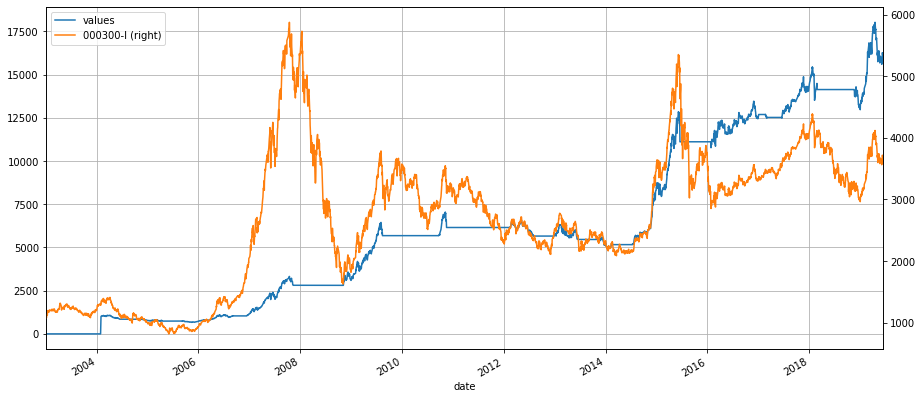

In [123]:
op.set_parameter('s-0', pars = ('Y', 1))
op.set_parameter('t-0', opt_tag = 1)

shares = ['600037', '600547', '000726', '600111', '600600', '600549', '000001',
          '000002', '000005', '000004', '000006', '000007', '000008']
shares = ['600037', '000005']
print ('Time of historical data extraction:')
# %time d = h.extract(shares, start='2005-01-15', end = '2019-10-15', interval = 'd')
opt = worker.optimizer
opt.shares = shares
opt.shares = ['000300-I']
# print ('Optimization Period:', opt.opt_period_start, opt.opt_period_end,opt.opt_period_freq)

if not d.empty:
    timing_pars1 = (86, 198, 58)
    timing_pars2 = {'600037':(177, 248, 244),
                    '000005':(86, 198, 58)}
    timing_pars3 = (72,130,133)
    timing_pars4 = (131,27)
    op.set_blender('timing', 'pos-1')
    op.set_parameter('t-0', pars = timing_pars1)
    #op.set_parameter('t-1', pars = timing_pars3)
    #op.set_parameter('t-2', pars = timing_pars4)
    #op.set_parameter('t-3', pars = timing_pars1)
    op.set_parameter('r-0', pars = (8, -0.1312))
    #op.info()
    #print('\nTime of creating operation list:')
    %time op_list = op.create(hist_extract=d)
else:
    print ('historical data is empty')

#print(op_list.head())
lper = opt.looper
ic = 1000
print('\nTime of looping operational list without visual:')
%time lper.apply_loop(op_list, d.fillna(0), init_cash=ic, MOQ = 0)
looped_values = lper.apply_loop(op_list, d.fillna(0), init_cash=ic, MOQ = 0)
#print('\nTime of looping operational list with visual')
looped_values_2 = lper.apply_loop(op_list, d.fillna(0), init_cash=ic, MOQ=0, visual = True, price_visual = True)
#print(looped_values.head())
ret = looped_values.value[-1] / looped_values.value[0]

years = (looped_values.index[-1] - looped_values.index[0]).days / 365.
print ('\nTotal investment years:',np.round(years,1), np.round(ret * 100 - 100, 3), '%, final value:', np.round(ret * ic, 2))
print ('Average Yearly return rate: ', np.round((ret ** (1 / years) - 1) * 100 , 3), '%')

In [ ]:
looped_values['2016-01-01':'2017-12-31']

In [ ]:
op_list['2016-01-01':'2017-12-31']

## Find Optimized Strategy Parameters with the Optimizer Object
the optimizer class is designed to search for local or global optimal strategy parameters in the parameter space of a given strategy, (the space is defined in the properties of the strategy)
the optimizer employees a series of different optimization methods or algorithms to search in fairly large parameter spaces, and previde quick results

In [ ]:

print('Total time used for optimization')
%time opt.start(how = 0, step_size=5, hist = d, output_count = 50) # how = 0, step_size / point_count = 5

## Download 5min, 15min and 30min kandle data with tushare pro

In [30]:
d = pd.read_csv('indices/data/000300_I_N.txt', index_col='date')
d.index = pd.to_datetime(d.index, format='%Y-%m-%d')
d.drop(labels=['open', 'high', 'low', 'volume', 'amount'], axis = 1, inplace=True)
d.columns = ['000300-I']
d = d[::-1]
d.head()


,000300-I
date,
2003-01-02,1074.984
2003-01-03,1073.524
2003-01-06,1084.884
2003-01-07,1081.622
2003-01-08,1111.832


In [ ]:
pro = ts.pro_api()
#data = pro.stock_basic(fields='ts_code,symbol,name,area')
#shares = data.ts_code
k = 0
for share in shares[1195:]:
    df = ts.pro_bar(ts_code=share, adj='qfq', start_date='19990101', end_date='20191011', freq='D')
    fname = 'Stock_History/daily/' + share[0:6] + '_daily.csv'
    df.to_csv(fname)
    print 'file saved!', share
    k += 1
    if k == 5:
        time.sleep(60) # 目前的tushare pro积分只能支持每分钟调用5次接口，因此调用5次后需要等待60秒
        k = 0
print 'completed!'

## RANKING TABLE
### Share selecting parameter research
share selecting class (ranking subclass) is the main share selecting class. it takes a "ranking table" as its main parameter on which selection is based. tha ranking table contains an array of numeric indicators with each column representing values in the same date and each row stands for the value of a specific share code. the ranking selection class simply takes N shares whose indicator value ranks N-th or larger than N-th value in a given date. 

creating the ranking table is the most important and first step of performing ranking selection. once selected, a simple timing strategy is used so that only selection class parameters are compared in optimization

In [ ]:
# generating the ranking table
report_type = 'report'
years = range(2007, 2019)
quarters = range(1, 5)
year = 2007
quarter = 1
indicator = 'eps'
fname = 'qteasy/finance_report/finance_'
#report = pd.read_csv(fname + str(year) + '_' + str(quarter) + '_report.csv', index_col='code')
ranking_table = pd.DataFrame()
#ranking_table[str(year)+str(quarter)] = report[indicator]
print ranking_table.head()
for year in years:
    for quarter in quarters:
        report = pd.read_csv(fname + str(year) + '_' + str(quarter) + '_report.csv',
                             index_col='code').drop(['Unnamed: 0'],
                                                    axis = 1).drop_duplicates().sort_index()
        #print 'got first report', str(year) + '_' + str(quarter)
        #print 'count of report', report[indicator].count()
        ranking_table = ranking_table.join(report[indicator], how='outer',
                                           rsuffix=str(year) + str(quarter))
        #print ranking_table.info()
        #print ranking_table.head()
        #print report[indicator].head()
print 'ranking table generated!' 
#print ranking_table.tail(50)
ranking_table = ranking_table.rename(index = six_str).drop_duplicates()
ranking_table_dates = pd.date_range(start = '2007-07-01', periods=48, freq='Q')
ranking_table.columns = ranking_table_dates
#print ranking_table.info()

#op._selecting.ranking_table(ranking_table)

### Update history warehouses:



In [ ]:
def six_str(n):
    s = str(n)
    l = len(s)
    if l < 6:
        s = '0' * (6 - l) + s
    return s

%time h.warehouse_open(price_type='close', interval = '30')
#%timeit h.warehouse_extract(shares=['600719', '300027'], start='2015-02-02', end = '2016-02-02')
#%timeit h.warehouse_get_last('600917')
#%timeit h.get_new_price('600719', interval='d')
#h.warehouse_close()
basics = pd.read_csv('qteasy/__share_basics.csv', index_col='code').rename(index = six_str)
shares = basics.index[:]
#shares = ['000693', '002070', '002680', '002356']
h.warehouse_update(shares, interval = '30')
#h.warehouse_close()
print 'completed'

h.warehouse_open(price_type='close', interval='30')
h.wh_is_open
h.warehouse_get_last('300693')

In [ ]:
h.warehouse_open(price_type='close', interval='d')
h.warehouse_get_last('600693')

# Extra functionalities

Next codes reads all previously saved stock history data and combine them into 5 different historical warehouse data

In [ ]:
all_share = pd.read_csv('qteasy/__share_basics.csv', index_col='code')
#%timeit all_share = pd.read_hdf('qteasy/__share_basics.hdf')
def six_str(n):
    s = str(n)
    l = len(s)
    if l < 6:
        s = '0' * (6 - l) + s
    return s
        
#all_share.head()
total = len(all_share.index)
#for i in range(total):
#    print all_share.index[i]
daily_open = pd.DataFrame()
daily_close = pd.DataFrame()
daily_high = pd.DataFrame()
daily_low = pd.DataFrame()
daily_volume = pd.DataFrame()
types = {'open': daily_open, 'close': daily_close, 'high': daily_high, 'low': daily_low,
        'volume': daily_volume}

for i in range(len(all_share.index)):
    share_code = six_str(all_share.index[i])
    fname = 'Stock_History/15_min/' + share_code + '_15min.csv'
    string = fname + str(i) + 'th of ' + str(total) 
    print string, '\r',
    if not share_code in ['600145', '002323', '300028', '000029', '600485']:
        try:
            stk = pd.read_csv(fname, index_col='date')
            #print stk.head()
            stk.index = pd.to_datetime(stk.index, format='%Y-%m-%d')
            #print stk.open.head()
            for tp in types:
                ser = pd.DataFrame(stk[tp])
                ser.rename({tp: share_code}, axis = 1, inplace = True)
                types[tp] = pd.merge(ser, types[tp],
                                      right_index=True, left_index=True, how='outer')
                #print types[tp].head()
        except:
            print('historical file {} could not be found'.format(share_code))
for tp in types:
    fname = 'qteasy/history/_share_15min_' + tp + '.csv'
    types[tp].to_csv(fname)
print 'file creation complete!'

### Read and combine parameter segments into a complete parameter document

In [ ]:
pars = pd.read_csv('strategies/DMA_0-9.csv', index_col=0)
rest_pars = ['10-19', '20-139', '140-259', '260-379', '380-529', '530-679', '680-799',
             '800-939', '940-1079', '1080-1379', '1380-1399', '1400-1999', '2000-2299',
             '2300-2591', '2592-2699', '2700-2807', '2808-3293', '3294-all']
for par in rest_pars:
    fname = 'strategies/DMA_' + par + '.csv'
    pars_add = pd.read_csv(fname, index_col=0)
    pars = pars.append(pars_add)
    print 'file merged: ', fname
pars.drop('DMA', axis = 1, inplace=True)
pars[['l','s','m']] = pars[['l','s','m']].astype('int')
print pars.info()
pars = pars.rename(index = six_str)
pars.head(20)
pars.to_csv('qteasy/strategies/DMA_all.csv')
pars.info()

### Investment Product Component: Foundamentals
Foundamentals are the basic data and parameters of the investment product

foundmental object is one of the components of the investment product, and is instantiated while the Share object is created. however, the data of Foundmentals can be created and loaded separatly

In [ ]:
class Foundamentals:
    def __init__(self, superior):
        self.__superior = superior
        

### update the historical sheets

In [ ]:
def chuquan(data):
    data = data[::-1][['close', 'price_change', 'p_change']].copy()
    data['price_close'] = (data.close.shift(1) + data.price_change - data.close).cumsum() + data.close
    #data['price_diff'] = (data.price - data.close).cumsum()
    #data['price'] = data.close + data.price_diff
    #data['check'] = abs(data.close - data.price) > 0.0001
    return data

data = ts.get_hist_data('600917', start = '2016-01-01')
cd = chuquan(data)
cd.head(20)

a quick way of calculating $B_i = a * A_i + B_{i-1}$

previous way uses iteration over pandas dataFrame object, which is very slow, new way employes cumsum() method to speed up

in the next example, two ways are employed to calculate $Price_i = Price_{i-1} + 5.0 * {Price\_change}_i$

In [ ]:
#method 1, iteration
P_iter = []
init_price = 25.0
for i in cd.itertuples():
    init_price = init_price * 1 + 5.0 * i[2]
    P_iter.append(init_price)
cd['p_iter'] = P_iter

#method 2, cumsum()
init_price = 25.0
cd['p_cumsum'] = (cd.price_change.cumsum() * 5.0 + init_price * 1)
cd.head()

In [ ]:
%timeit 25 * 0.9 + 5 * 0.21
%time 23.55 * ( 0.9 + 5 ) * 1.26